# Exploratory Data Analysis Notebook

Welcome to the Exploratory Data Analysis (EDA) Notebook. EDA is all about understanding the data, gaining insights, and identifying patterns which will inform how we model the data.

In this part of the project, we're going to dig into our movie data to see what makes a movie successful. We're looking at success in three different ways:

**Return on Investment (ROI):**

ROI is a performance measure used to evaluate the efficiency or profitability of an investment, or to compare the efficiency of different investments. In the context of movies, it's computed as the ratio of revenue to budget. This metric is crucial as it helps investors understand the financial return they might expect from their investment in a particular movie. It's a clear indicator of financial success.

**Rating Metric:**
Ratings are critical in the movie industry as they reflect the audience's reception. In this analysis, we intend to aggregate ratings from different rating systems to form an overall rating metric. This will provide a more holistic view of a movie's reception across various platforms and audiences.

**Awards Metric:**
Awards and nominations are a testament to a movie's quality and acceptance within the industry. They can significantly boost a movie's reputation and, by extension, its financial success. Creating an awards metric will help in understanding the recognition a movie has received in the industry.

Now, we'll go through our data, looking at how different bits of information (like the movie's genre or the month it was released) might affect these three success measures. This will help us later when we build our model to predict a movie's success.

## Objectives:
- **Distribution Analysis**: Understanding the distribution of various features.
- **Outlier Detection**: Detecting and handling outliers.
- **Correlation Analysis**: Identifying relationships between different variables.
- **Trend Analysis**: Discovering trends within the data.
- **Feature Engineering**: Creating new features to better capture the underlying patterns in the data.

## Dataset:
In this notebook, we will be working with the cleaned dataset located at `./data/cleaned/movies_dataset.parquet`, which is the result of the cleaning process carried out in the preceding Data Cleaning Notebook.


In [1115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

In [1116]:
df = pd.read_parquet('../data/cleaned/movies_dataset.parquet')

In [1117]:
# Set the float format to display the entire number
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,release_year,release_month,runtime,tmdb_popularity,tmdb_rating,tmdb_vote_count,oscar_won,oscar_nominated,bafta_won,bafta_nominated,awards_won,awards_nominated,rotten_tomatoes_rating,metacritic_rating,imdb_rating,imdb_votes,adjusted_budget,adjusted_revenue,adjusted_boxoffice
count,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00,6257.00,5565.00,7478.00,7482.00,7485.00,7485.00,5881.00
mean,1999.46,6.93,108.98,18.79,63.11,1753.43,0.14,0.22,0.01,0.02,5.96,11.37,56.21,55.33,63.55,99282.91,44291629.38,132477545.85,81585304.61
std,14.83,3.38,22.24,19.96,9.89,3227.62,0.73,0.81,0.10,0.21,15.15,23.95,27.98,18.24,10.76,191830.37,55106777.88,261200915.27,133013103.93
min,1947.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,12.00,6.00,1929.38,1387.86,153.56
25%,1992.00,4.00,94.00,8.38,58.00,130.00,0.00,0.00,0.00,0.00,0.00,1.00,33.00,42.00,57.00,8164.00,8042376.92,7596025.00,6679396.95
50%,2004.00,7.00,105.00,14.16,63.78,543.00,0.00,0.00,0.00,0.00,1.00,4.00,59.00,56.00,64.00,32543.50,25336974.65,38989575.51,37588369.17
75%,2010.00,10.00,120.00,22.59,69.43,1794.00,0.00,0.00,0.00,0.00,5.00,11.00,81.00,68.00,71.00,105424.75,56411798.83,134424106.96,101051095.47
max,2023.00,12.00,310.00,376.69,100.00,34612.00,11.00,11.00,4.00,5.00,245.00,337.00,100.00,100.00,93.00,2802199.00,512244953.43,4254454876.30,2326748295.11


### ROI

First of all, I'm going to calculate ROI. ROI is calculated by taking the total revenue of a movie, subtracting the budget, and then dividing by the budget once more.

Formula (revenue - budget) / budget * 100%

Now, why do we use the revenue and budget columns to calculate ROI and not consider the BoxOffice column?

The revenue column typically represents the global revenue generated by a movie, encompassing not just box office revenue but also other revenue streams like home video sales, TV rights, and merchandise. Also, the revenue and budget columns have more complete data as compared to the BoxOffice column, which has a number of missing values. Utilizing columns with more complete data allows for a more accurate and reliable calculation of ROI.


In [1118]:
df[['adjusted_budget', 'adjusted_revenue', 'adjusted_boxoffice']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7485 entries, 0 to 7929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adjusted_budget     7485 non-null   float64
 1   adjusted_revenue    7485 non-null   float64
 2   adjusted_boxoffice  5881 non-null   float64
dtypes: float64(3)
memory usage: 233.9 KB


Look at characteristics of revenue and budget in our dataset
Plot log and non logged dat

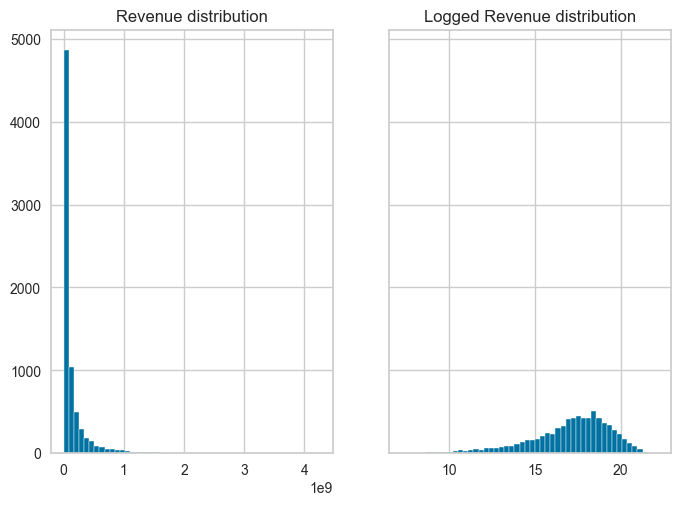

In [1119]:
#Plot movie revenue data both logged and non logged
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df['adjusted_revenue'], bins=50)
axs[0].set_title('Revenue distribution')
axs[1].hist(np.log(df['adjusted_revenue']), bins=50)
axs[1].set_title('Logged Revenue distribution')
plt.show()

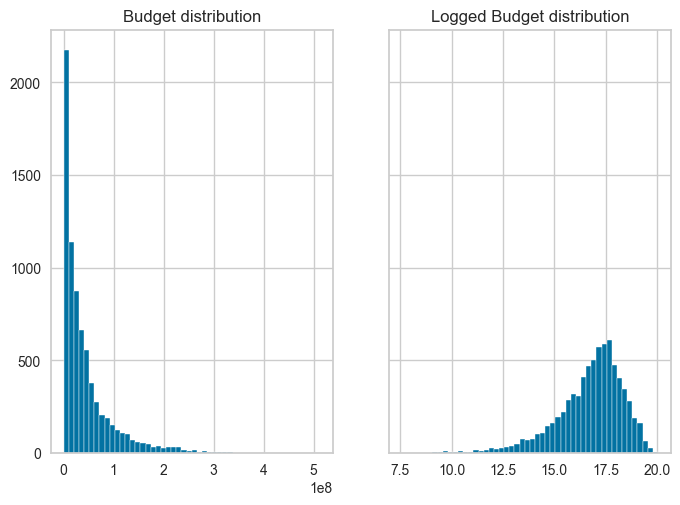

In [1120]:
#Plot movie budget data both logged and non logged
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df['adjusted_budget'], bins=50)
axs[0].set_title('Budget distribution')
axs[1].hist(np.log(df['adjusted_budget']), bins=50)
axs[1].set_title('Logged Budget distribution')
plt.show()

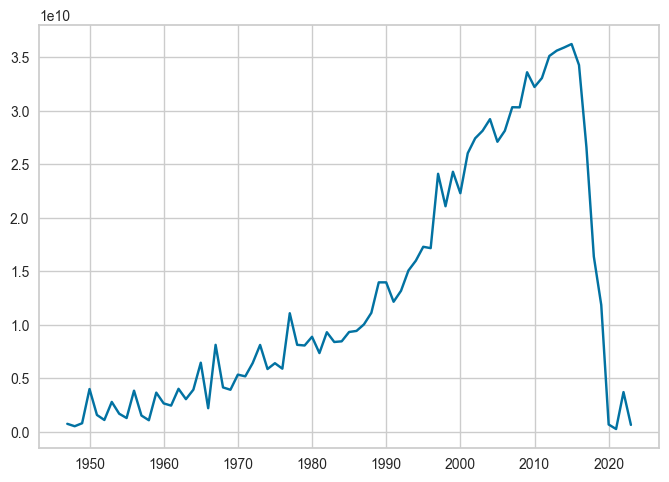

In [1121]:
#Print out yearly adjusted revenue
plot_rev = df.groupby(['release_year'])['adjusted_revenue'].agg('sum')
plt.plot(plot_rev )

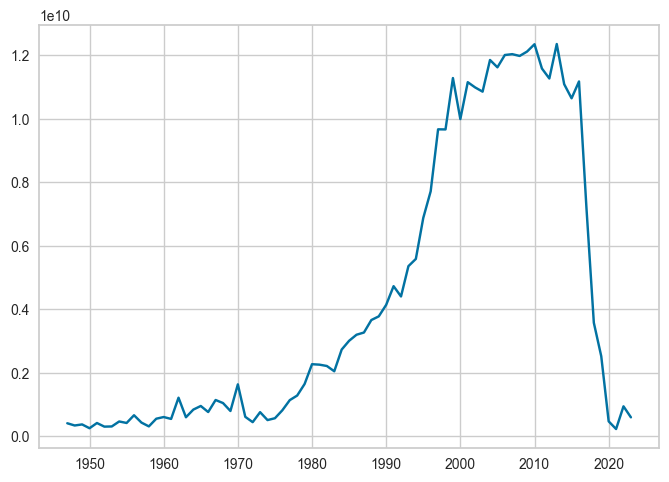

In [1122]:
#Print out yearly adjusted budget
plot_rev = df.groupby(['release_year'])['adjusted_budget'].agg('sum')
plt.plot(plot_rev)

#### Note on Revenue and Budget Drop After 2013

The graphs above show a drop in yearly adjusted revenue and adjusted budget around 2013. This drop matches with a decrease in the number of movies in the dataset during the same period on the graph below. So, the drop in revenue and budget is likely due to having fewer movies in the dataset after 2013, not a real decrease in the movie industry revenue or budget.


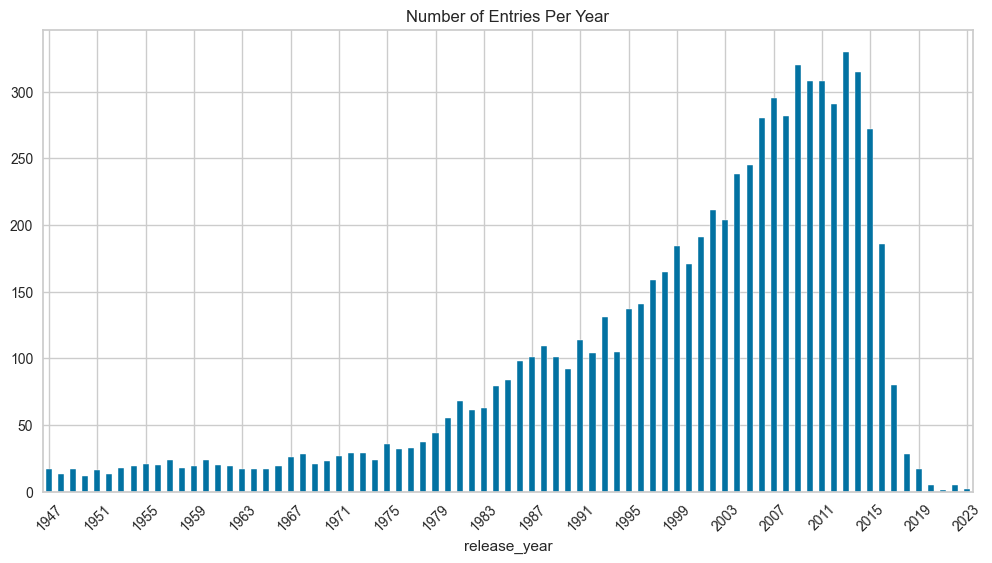

In [1123]:
entries_per_year = df.groupby('release_year').size()
entries_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Entries Per Year')
plt.xticks(rotation=45) 
plt.locator_params(axis='x', nbins=20)
plt.show()


Formula ROI = (revenue - budget) / budget * 100%

In [1124]:
df['adjusted_ROI'] = ((df['adjusted_revenue'] - df['adjusted_budget']) / df['adjusted_budget']) * 100


In [1125]:
df[['adjusted_ROI']].describe().style

,adjusted_ROI
count,7485.000000
mean,541.187218
std,7334.355872
min,-99.992927
25%,-35.482179
50%,84.369227
75%,295.571119
max,414298.498333


It's evident that the distribution of ROI (Return on Investment) is highly skewed with extreme outliers. This huge discrepancy between the maximum value and the 75th percentile, along with the large standard deviation, confirms the presence of extreme outliers in the data.

Let's look at what percentile our outliers lie and how many and what those movies are.

0.75      295.57
0.95     1340.58
0.99     6209.87
0.99    10767.43
1.00   414298.50
Name: adjusted_ROI, dtype: float64


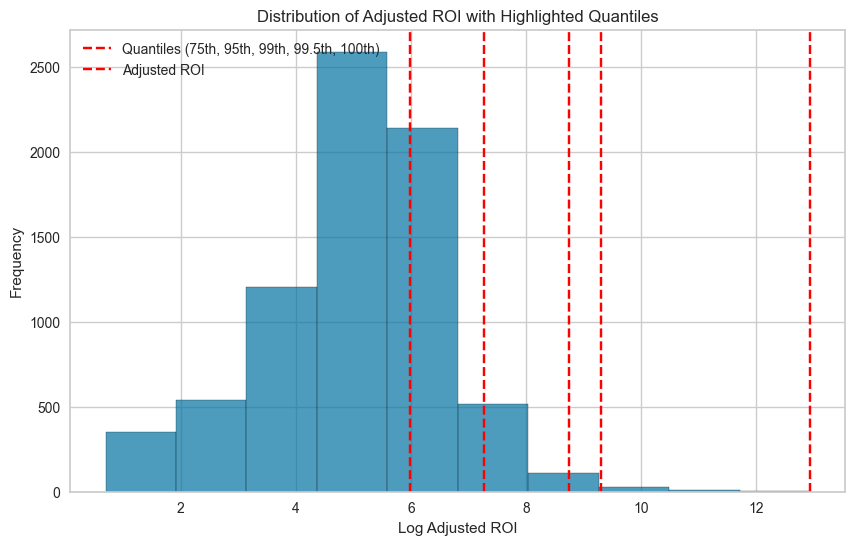

In [1126]:
set_df = df.copy()
percentiles = df['adjusted_ROI'].quantile([0.75, 0.95, 0.99, 0.995, 1])
print(percentiles)

# let's see quantiles on the graph, but first let's apply log adjusted_ROI for better visualization and analysis

# remove the negative numbers
set_df['log_adjusted_ROI'] = np.log1p(set_df['adjusted_ROI'] - set_df['adjusted_ROI'].min() + 1)
log_quantiles = set_df['log_adjusted_ROI'].quantile([0.75, 0.95, 0.99, 0.995, 1])

plt.figure(figsize=(10, 6))
plt.hist(set_df['log_adjusted_ROI'], bins=10, edgecolor='k', alpha=0.7)
for quantile in log_quantiles:
    plt.axvline(x=quantile, color='red', linestyle='--')
plt.xlabel('Log Adjusted ROI')
plt.ylabel('Frequency')
plt.title('Distribution of Adjusted ROI with Highlighted Quantiles')
plt.legend(['Quantiles (75th, 95th, 99th, 99.5th, 100th)', 'Adjusted ROI'])
plt.grid(True)
plt.show()


So you can see that outliers from the right side is somewhere between 99.5% and 100%. Let's see the list of the most profitable movies

In [1127]:
quantile_99 = set_df['adjusted_ROI'].quantile(0.995)
max_value = set_df['adjusted_ROI'].max()  # This corresponds to the 100th percentile

count_between = set_df[(set_df['adjusted_ROI'] > quantile_99) & (set_df['adjusted_ROI'] <= max_value)].shape[0]

print(f'Number of values between 99th and 100th percentiles: {count_between}')

set_df[(set_df['adjusted_ROI'] > quantile_99) & (set_df['adjusted_ROI'] <= max_value)][['title', "adjusted_ROI", "adjusted_budget", "adjusted_revenue"]].sort_values(by='adjusted_ROI', ascending=False)


Number of values between 99th and 100th percentiles: 38


,title,adjusted_ROI,adjusted_budget,adjusted_revenue
2099,the blair witch project,414298.50,109360.89,453189876.90
4686,deep throat,399900.00,182158.87,728635491.61
1937,1 night in paris,178631.01,8999.42,16084753.84
5325,paranormal activity,89832.93,313242.65,281708294.19
2607,lady frankenstein,69741.50,1485775.06,1037687589.32
1961,"aloha, bobby and rose",58233.33,343970.94,200649716.98
581,pink flamingos,49900.00,88069.86,44034927.54
7464,the gallows,42864.41,127646.05,54842372.51
953,open water,41952.27,213625.37,89834320.23
3699,behind the green door,41566.67,428952.00,178730000.00


I checked first 2 outliers - [The_Blair_Witch_Project](https://en.wikipedia.org/wiki/The_Blair_Witch_Project) and [Deep_Throat](https://en.wikipedia.org/wiki/Deep_Throat_(film)) and they indeed have very high ROI so they look legit.

Additionaly, I googled 'good ROI in movie industry' so I got different answers, but most of them were "3x its budget". This rule suggests that for a movie to be considered financially successful, it should earn at least three times its production budget. This is because the production budget often only accounts for the costs of filming. There are many other expenses, like marketing, distribution, and operational costs, that are also incurred during a movie's release.

If you look at ROI distribution you also might notice that ROI=300 is almost 75th percentile.

Here's how we'll label the ROI based on the "3x its budget" rule to indicate whether a movie is a hit or a flop:

- **ROI < 300% (or 3x its budget): Flop**

If a movie's ROI is less than 300%, it means the revenue generated didn't cover the production budget and the additional expenses to a satisfactory extent. It's a sign of financial underperformance, and hence, we label it as a 'flop'.

- **ROI ≥ 300% (or 3x its budget): Hit**

Conversely, if a movie's ROI is 300% or higher, it suggests that the revenue generated was substantial, covering the production budget and the additional expenses, with a healthy profit margin. Therefore, we label it as a 'hit'.
Labeling movies in this manner will help us, and any potential investors or stakeholders, quickly identify the financial performance of movies in our dataset

In [1128]:
def categorize_roi(roi):
    if roi < 300:
        return 'flop'
    else:
        return 'hit'

df['ROI_category'] = df['adjusted_ROI'].apply(categorize_roi)

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_ROI_category'] = df['ROI_category'].map(label_mapping)

df.drop(['ROI_category', 'adjusted_boxoffice'], axis=1, inplace=True)

### Ratings

In [1129]:
print(df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']].info())
df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']].describe().transpose()

<class 'pandas.core.frame.DataFrame'>
Index: 7485 entries, 0 to 7929
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tmdb_rating             7485 non-null   float64
 1   tmdb_vote_count         7485 non-null   int64  
 2   imdb_rating             7478 non-null   float64
 3   imdb_votes              7482 non-null   float64
 4   rotten_tomatoes_rating  6257 non-null   float64
 5   metacritic_rating       5565 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 409.3 KB
None


,count,mean,std,min,25%,50%,75%,max
tmdb_rating,7485.00,63.11,9.89,0.00,58.00,63.78,69.43,100.00
tmdb_vote_count,7485.00,1753.43,3227.62,0.00,130.00,543.00,1794.00,34612.00
imdb_rating,7478.00,63.55,10.76,12.00,57.00,64.00,71.00,93.00
imdb_votes,7482.00,99282.91,191830.37,6.00,8164.00,32543.50,105424.75,2802199.00
rotten_tomatoes_rating,6257.00,56.21,27.98,0.00,33.00,59.00,81.00,100.00
metacritic_rating,5565.00,55.33,18.24,1.00,42.00,56.00,68.00,100.00


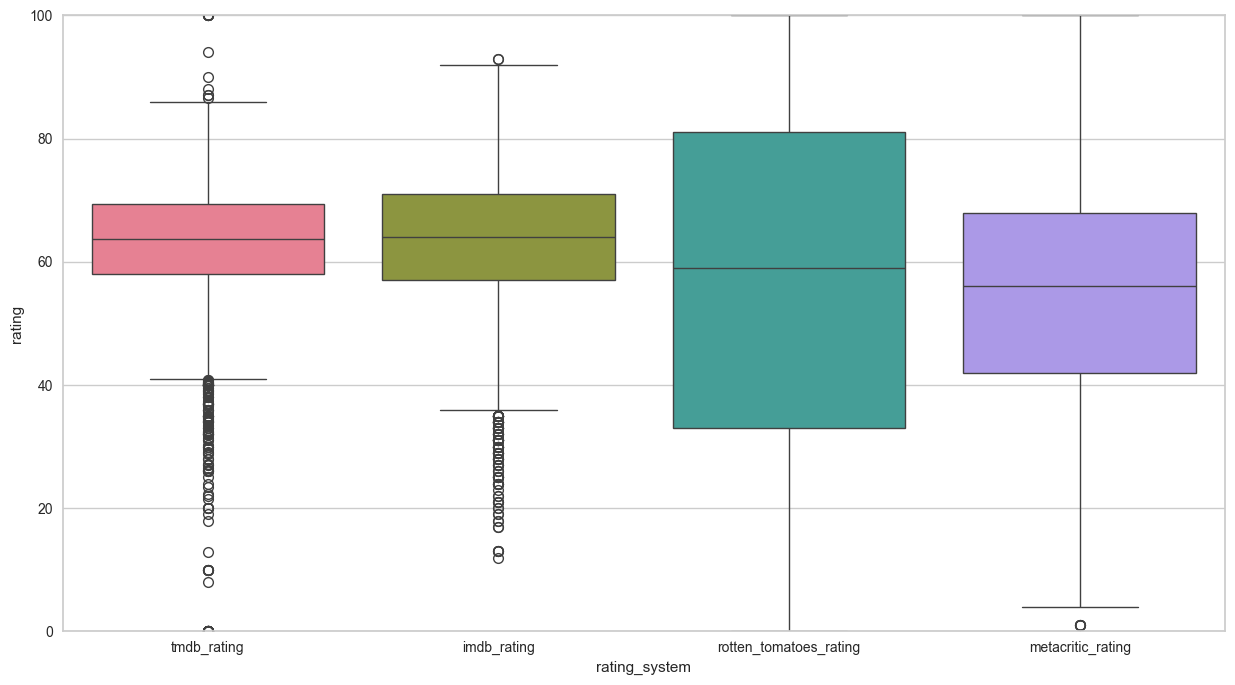

In [1130]:
melted_df = df.melt(value_vars=['tmdb_rating', 'imdb_rating', 'rotten_tomatoes_rating', 'metacritic_rating'],
                    var_name='rating_system', value_name='rating')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.boxplot(x='rating_system', y='rating', data=melted_df, palette="husl", hue='rating_system', ax=ax)
ax.set_ylim([0, 100])  

plt.show()

In [1131]:
zero_counts = (df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']] == 0).sum()

print(zero_counts)


tmdb_rating               20
tmdb_vote_count           20
imdb_rating                0
imdb_votes                 0
rotten_tomatoes_rating    78
metacritic_rating          0
dtype: int64


In our dataset, we have access to the number of votes a movie has received on both TMDB (tmdb_vote_count) and IMDb (imdb_votes). It's a well-observed phenomenon that the rating of a movie can significantly depend on the number of votes it has received; a movie with a higher number of votes is likely to have a more reliable rating as compared to a movie with fewer votes. This is because a larger voting pool reduces the chance of skewed ratings.

To account for this voting discrepancy and to provide a balanced view of a movie's rating, I will apply a Weighted Rating Formula. This formula not only considers the average rating of a movie but also the number of votes it has garnered. By doing so, it gives us a more conservative estimate of a movie’s rating, particularly when the movie has fewer votes. This weighted rating thus corrects the bias in rating due to a varied number of votes, offering a more accurate reflection of a movie's popularity and quality. 

**Adjusting Ratings based on Vote Counts:**

A weighted rating formula is often used to compute a score that reflects both the average rating of an item and the number of ratings the item has received. This helps to give a more balanced view of the item's popularity and quality, compared to simply using the average rating which can be easily skewed by a small number of high or low ratings.

One common formula used for this purpose is the IMDb (Internet Movie Database) weighted rating formula, which is as follows:

Weighted Rating(WR) = (v/(v+m))*R + (m/(v+m)) * C
where:

- v is the number of votes for the item,
- m is the minimum number of votes required for the item to be listed,
- R is the average rating of the item,
- C is the mean rating across the whole dataset.

the 70th percentile (0.70 quantile) is used to set a threshold for the minimum number of votes a movie must have to be included in the weighted rating calculation. This means that only movies with a number of votes higher than 70% of the movies in the dataset will have a weighted rating significantly influenced by their own average rating. For movies with a number of votes below this threshold, the global average rating will have a more significant influence on their weighted rating.

In [1132]:
m = df['tmdb_vote_count'].quantile(0.70)  # minimum votes required to be listed
C = df['tmdb_rating'].mean()  # mean rating across the whole dataset

print('tmdb minimum votes:', m)
print('tmdb mean rating across the whole dataset:', C)

# Function to compute weighted rating
def weighted_rating(x, m=m, C=C):
    v = x['tmdb_vote_count']
    R = x['tmdb_rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

df['weighted_tmdb_rating'] = df.apply(weighted_rating, axis=1)

m = df['imdb_votes'].quantile(0.70)  # minimum votes required to be listed
C = df['imdb_rating'].mean()  # mean rating across the whole dataset

print('imdb minimum votes:', m)
print('imdb mean rating across the whole dataset:', C)

# Function to compute weighted rating
def weighted_rating(x, m=m, C=C):
    v = x['imdb_votes']
    R = x['imdb_rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

df['weighted_imdb_rating'] = df.apply(weighted_rating, axis=1)

df[['imdb_rating', 'imdb_votes', 'weighted_tmdb_rating',  'tmdb_vote_count',  'tmdb_rating','weighted_imdb_rating', 'rotten_tomatoes_rating',	'metacritic_rating']].describe().style


tmdb minimum votes: 1418.0
tmdb mean rating across the whole dataset: 63.10702738810955
imdb minimum votes: 82871.39999999998
imdb mean rating across the whole dataset: 63.55335651243648


,imdb_rating,imdb_votes,weighted_tmdb_rating,tmdb_vote_count,tmdb_rating,weighted_imdb_rating,rotten_tomatoes_rating,metacritic_rating
count,7478.000000,7482.000000,7485.000000,7485.000000,7485.000000,7478.000000,6257.000000,5565.000000
mean,63.553357,99282.912056,64.292624,1753.432999,63.107027,64.854148,56.213361,55.325067
std,10.758242,191830.374383,3.877418,3227.616852,9.893300,4.545082,27.976367,18.240293
min,12.000000,6.000000,43.463511,0.000000,0.000000,39.918216,0.000000,1.000000
25%,57.000000,8164.000000,62.577450,130.000000,58.000000,62.869291,33.000000,42.000000
50%,64.000000,32543.500000,63.144374,543.000000,63.780000,63.638188,59.000000,56.000000
75%,71.000000,105424.750000,65.067436,1794.000000,69.430000,65.919137,81.000000,68.000000
max,93.000000,2802199.000000,85.730675,34612.000000,100.000000,92.154168,100.000000,100.000000


The weighted rating formula helps in balancing the ratings, especially for movies with a lower number of votes. Movies with fewer votes are pulled towards the mean rating to a greater extent than movies with a higher number of votes. This reduces the likelihood of extreme ratings for movies with few votes, making the distribution of ratings more balanced and less skewed. Movies with a higher vote count have ratings that are more reflective of the general audience's opinion, and their weighted ratings are less affected by the formula. 

By regressing ratings towards the mean, the formula reduces the influence of outlier ratings. This is particularly useful when there are movies with very high or very low ratings but with a small number of votes, which could otherwise distort the overall distribution.

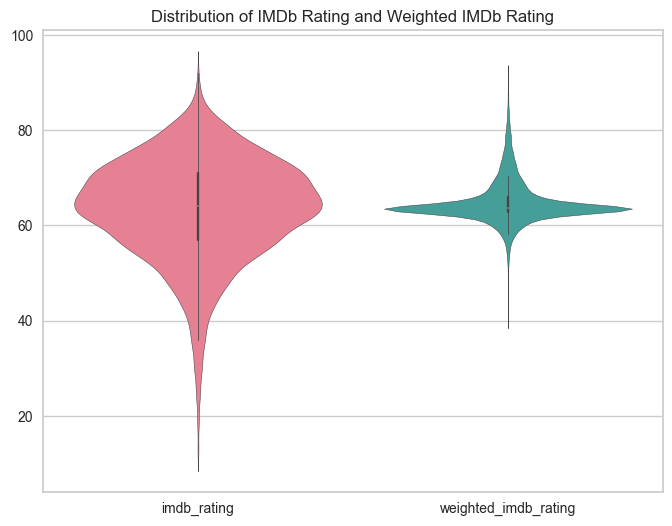

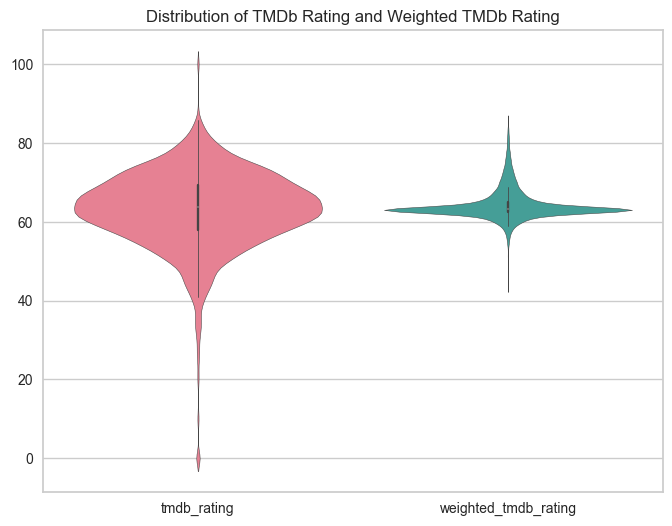

In [1133]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df[['imdb_rating', 'weighted_imdb_rating']], palette="husl")
plt.title('Distribution of IMDb Rating and Weighted IMDb Rating')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=df[['tmdb_rating', 'weighted_tmdb_rating']], palette="husl")
plt.title('Distribution of TMDb Rating and Weighted TMDb Rating')
plt.show()


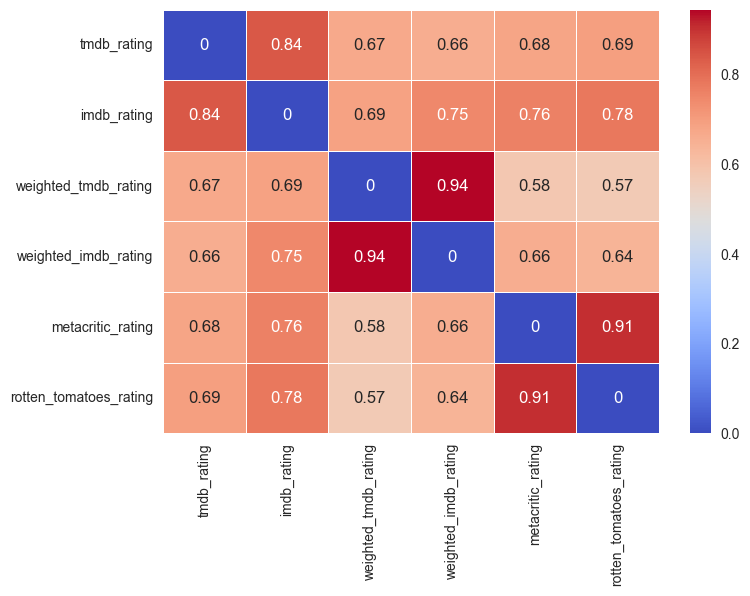

('weighted_tmdb_rating', 'weighted_imdb_rating')


In [1134]:
corr_matrix = df[[ "tmdb_rating", 'imdb_rating', 
                             "weighted_tmdb_rating", 'weighted_imdb_rating', 
                             'metacritic_rating', 'rotten_tomatoes_rating']].corr()

# Compute the correlation matrix between ratings
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm' , linewidth=.5)

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)


The correlation coefficient of 0.96 between normalized_weighted_tmdb_rating and normalized_weighted_imdb_rating indicates a very strong positive linear relationship between these two variables. It makes sense to average them separately as they might be capturing similar aspects of the movie's quality.

Also in cases where weighted_imdb_rating is null, we can take only weighted_tmdb_rating number instead

In [1135]:
df['average_rating'] = np.where(df['weighted_imdb_rating'].isnull(), 
                                df['weighted_tmdb_rating'], 
                                (df['weighted_tmdb_rating'] + df['weighted_imdb_rating']) / 2)


# let's look at the top rates movies
top_movies = df.sort_values(by='average_rating', ascending=False)
top_movies[['title', 'average_rating']].head(15)


,title,average_rating
4852,the shawshank redemption,88.94
4827,the godfather,88.12
6492,the dark knight,86.69
6474,the lord of the rings: the return of the king,86.18
4115,schindler's list,86.13
4829,the godfather part ii,85.91
574,pulp fiction,85.90
915,forrest gump,85.37
2497,fight club,85.23
3519,inception,85.02


I'm not going to use metacritic and rotten tomatoes rating in this analysis. It's possible to fill the missing data in those ratings by mean for example, but it still demands to include those 2 ratings into the raiting formula metric which will increase complexity.

Currently for simplicity we aim to categorize movies into 'hit' or 'flop' based on their average ratings.
I chose a simplistic approach to label the top 25% of movies (in terms of average_rating) as 'hit', while the remaining 75% are labeled as 'flop'. This is a straightforward method to distinguish higher-rated movies from the lower-rated ones.

In [1136]:
df['rating_category'] = 'flop' 
top_25_percentile_threshold = df['average_rating'].quantile(0.75)  
df.loc[df['average_rating'] >= top_25_percentile_threshold, 'rating_category'] = 'hit'  

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_rating_category'] = df['rating_category'].map(label_mapping)
df.drop(['rating_category', 
                             'rotten_tomatoes_rating', 'metacritic_rating', 'imdb_rating', 'tmdb_rating',  
                             'weighted_imdb_rating', 'weighted_tmdb_rating', 'tmdb_vote_count', 'imdb_votes'], axis=1, inplace=True)


### Awards

In [1137]:
df[['oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']].describe()

,oscar_won,oscar_nominated,bafta_won,bafta_nominated,awards_won,awards_nominated
count,7485.00,7485.00,7485.00,7485.00,7485.00,7485.00
mean,0.14,0.22,0.01,0.02,5.96,11.37
std,0.73,0.81,0.10,0.21,15.15,23.95
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,1.00
50%,0.00,0.00,0.00,0.00,1.00,4.00
75%,0.00,0.00,0.00,0.00,5.00,11.00
max,11.00,11.00,4.00,5.00,245.00,337.00


In [1138]:
# Top 10 movies by oscar_won
top10_oscar_won = df.nlargest(10, 'oscar_won')

# Top 10 movies by bafta_won
top10_bafta_won = df.nlargest(10, 'bafta_won')

# Top 10 movies by awards_won
top10_awards_won = df.nlargest(10, 'awards_won')

print("Top 10 movies by Oscar wins:")
print(top10_oscar_won[['title', 'oscar_won']])

print("\nTop 10 movies by BAFTA wins:")
print(top10_bafta_won[['title', 'bafta_won']])

print("\nTop 10 movies by Total awards won:")
print(top10_awards_won[['title', 'awards_won']])


Top 10 movies by Oscar wins:
                                              title  oscar_won
562                                         ben-hur         11
2532                                        titanic         11
6474  the lord of the rings: the return of the king         11
1355                                west side story         10
3279                                           gigi          9
3632                               the last emperor          9
4109                            the english patient          9
555                               on the waterfront          8
1682                                   my fair lady          8
1806                          from here to eternity          8

Top 10 movies by BAFTA wins:
                                        title  bafta_won
4692                         a bridge too far          4
3056                        strictly ballroom          3
83                       pink floyd: the wall          2
1120                

I referred to this link to gather some additional info on movie awards: https://www.imdb.com/title/<IMDB_ID>/awards/. The columns awards_won and awards_nominated obviously represent the total count of all awards won and nominated respectively.

For instance, if we consider 'The Lord of the Rings: The Return of the King' (link) or 'Titanic' (link), it's evident from the dataset that only the Oscars are mentioned. However, there's no mention of BAFTA awards, which might suggest that the dataset primarily highlights the most prestigious award(s) a movie has received.

Let's check my theory if we have for any movie oscar and bafta together:

In [1139]:

titles_of_interest = ['titanic', 'the lord of the rings: the return of the king']
filtered_rows = df[df['title'].isin(titles_of_interest)]
print(filtered_rows[['oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']])

non_empty_awards_rows = df[(df['oscar_won'].notnull() & df['oscar_won'] > 0) & (df['bafta_won'].notnull() & df['bafta_won'] > 0)]
print(non_empty_awards_rows)

      oscar_won  oscar_nominated  bafta_won  bafta_nominated  awards_won  \
1206          1                0          0                0           1   
2532         11                0          0                0         126   
6474         11                0          0                0         215   

      awards_nominated  
1206                 3  
2532                83  
6474               124  
Empty DataFrame
Columns: [title, release_year, release_month, original_language, spoken_languages, genres, production_companies, production_countries, runtime, rated, tagline, overview, plot, tmdb_popularity, cast, crew, belongs_to_collection.name, oscar_won, oscar_nominated, bafta_won, bafta_nominated, awards_won, awards_nominated, adjusted_budget, adjusted_revenue, adjusted_ROI, numerical_ROI_category, average_rating, numerical_rating_category]
Index: []

[0 rows x 29 columns]


We can create a Points System to combine these awards into one score. We'll give more points for winning awards and some extra points for nominations. Oscars will get the highest points, followed by BAFTA, and then other awards. We'll also take out the BAFTA and Oscar counts from the total awards number.

Points:

Oscar Win: 5 points
Oscar Nomination: 3 points
BAFTA Win: 4 points
BAFTA Nomination: 2 points
Other Award Win: 3 points
Other Award Nomination: 1 point"

In [1140]:
df['award_points'] = (df['oscar_won'] * 5 + df['oscar_nominated'] * 3 +
                      df['bafta_won'] * 4 + df['bafta_nominated'] * 2 +
                      (df['awards_won'] - df['oscar_won'] - df['bafta_won']) * 3 + 
                      (df['awards_nominated'] - df['oscar_nominated'] - df['bafta_nominated']) * 1)

df[['award_points', 'oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']]

,award_points,oscar_won,oscar_nominated,bafta_won,bafta_nominated,awards_won,awards_nominated
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,43,4,0,0,0,9,8
4,3,0,0,0,0,0,3
5,3,0,0,0,0,0,3
...,...,...,...,...,...,...,...
7925,55,0,0,0,0,8,31
7926,12,0,0,0,0,3,3
7927,3,0,0,0,0,1,0
7928,4,0,0,0,0,1,1


count   7485.00
mean      30.01
std       67.82
min        0.00
25%        2.00
50%        8.00
75%       27.00
max     1069.00
Name: award_points, dtype: float64


/var/folders/_g/dcc1mh151c37cqym56jdsb0w0000gn/T/ipykernel_63998/1283950992.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




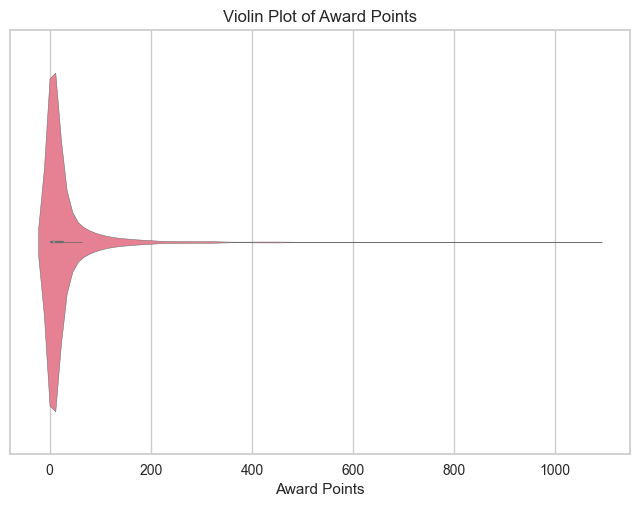

In [1141]:
print(df['award_points'].describe())
sns.violinplot(x=df['award_points'], palette="husl")
plt.title('Violin Plot of Award Points')
plt.xlabel('Award Points')
plt.show()


the top 25% of the movies based on award points are labeled as 'hit' while the rest are labeled as 'flop'. This threshold is chosen to maintain consistency with the methodology applied to other metrics like ROI and average ratings. 

In [1142]:
# Determine the 75th percentile value
threshold = df['award_points'].quantile(0.75)

df['award_category'] = ['hit' if x >= threshold else 'flop' for x in df['award_points']]

print(df[['award_points', 'award_category']].head())

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_award_category'] = df['award_category'].map(label_mapping)
df.drop(['award_category', 'oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated'], axis=1, inplace=True)


   award_points award_category
0             0           flop
1             0           flop
2            43            hit
4             3           flop
5             3           flop


### Metrics correlation

Let's look at our metrics correlation

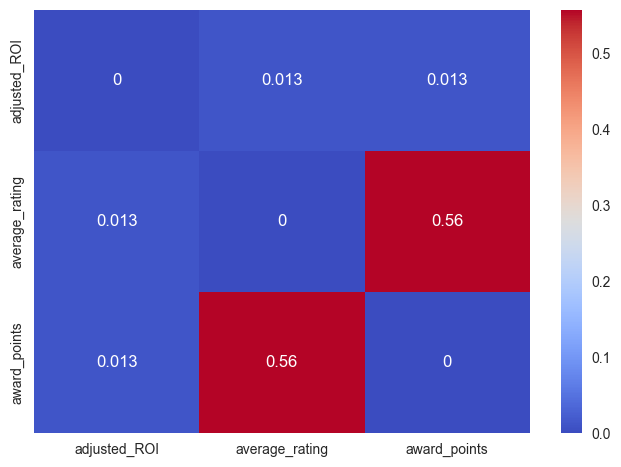

('average_rating', 'award_points')


In [1143]:
corr_matrix = df[[ "adjusted_ROI", 'average_rating', 
                             "award_points"]].corr()

# Compute the correlation matrix between labels
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)

# !TODO: write about connection between labels that we should use model that catch this correlation

The correlation number between 'average_rating' and 'award_points' shows that there is a somewhat strong link between the average rating of a movie and the award points it gets. Basically, if a movie has a higher rating, it's somewhat more likely to have more award points too. This makes sense because good movies are often liked by viewers and also get awards.

But, a 0.55 number isn't super strong, so there are probably other things affecting award points that we're not seeing here. And just because two things are linked doesn't mean one causes the other.

there's pretty much no relationship between a movie's Return on Investment (ROI) and its average rating or award points. In other words, just because a movie makes more money (has a higher ROI), it doesn’t mean people will rate it higher or that it will win more awards. And vice versa, a well-rated movie or a movie with lots of awards doesn’t necessarily make more money.

The idea here is that a movie can be successful in many ways - it could make a lot of money, people could love it, or it could win a lot of awards. Our numbers are helping us see these different kinds of success and how they relate to each other.

Let's find the most successful movies in each category:

In [1144]:
# Top 10 movies by adjusted_ROI
top10_ROI = df.nlargest(10, 'adjusted_ROI')

# Top 10 movies by average_rating
top10_rating = df.nlargest(10, 'average_rating')

# Top 10 movies by award_points
top10_awards_won = df.nlargest(10, 'award_points')

# To display the top 10 lists
print("Top 10 movies by ROI metric:")
print(top10_ROI[['title', 'adjusted_ROI']])

print("\nTop 10 movies by rating matric:")
print(top10_rating[['title', 'average_rating']])

print("\nTop 10 movies by award metric:")
print(top10_awards_won[['title', 'award_points']])


Top 10 movies by ROI metric:
                        title  adjusted_ROI
2099  the blair witch project     414298.50
4686              deep throat     399900.00
1937         1 night in paris     178631.01
5325      paranormal activity      89832.93
2607        lady frankenstein      69741.50
1961    aloha, bobby and rose      58233.33
581            pink flamingos      49900.00
7464              the gallows      42864.41
953                open water      41952.27
3699    behind the green door      41566.67

Top 10 movies by rating matric:
                                              title  average_rating
4852                       the shawshank redemption           88.94
4827                                  the godfather           88.12
6492                                the dark knight           86.69
6474  the lord of the rings: the return of the king           86.18
4115                               schindler's list           86.13
4829                          the godfather pa

In [1145]:
# Anti Top 10 movies by adjusted_ROI
top10_ROI = df.nsmallest(10, 'adjusted_ROI')

# Anti Top 10 movies by average_rating
top10_rating = df.nsmallest(10, 'average_rating')

# To display the top 10 lists
print("Anti Top 10 movies by ROI metric:")
print(top10_ROI[['title', 'adjusted_ROI']])

print("\n Anti Top 10 movies by rating matric:")
print(top10_rating[['title', 'average_rating']])


Anti Top 10 movies by ROI metric:
                                           title  adjusted_ROI
6709                                   java heat        -99.99
5949                               the samaritan        -99.98
6940  the adventurer: the curse of the midas box        -99.97
6565                             the guillotines        -99.96
7727                                    the duel        -99.95
4539                        the velocity of gary        -99.95
6111                  philadelphia experiment ii        -99.94
1488                                   fishtales        -99.93
3983                             the good doctor        -99.91
146                                      absolon        -99.91

 Anti Top 10 movies by rating matric:
                     title  average_rating
4221  dragonball evolution           44.16
4187        disaster movie           45.30
4112        batman & robin           46.03
5126            epic movie           46.08
5746     meet the s

### Features

#### Budget

In [1146]:
df['log_adjusted_budget'] = np.log(df['adjusted_budget'])

#low_budget_threshold = df['adjusted_budget'].quantile(0.2)
#high_budget_threshold = df['adjusted_budget'].quantile(0.5)

#conditions = [
#    df['adjusted_budget'] <= low_budget_threshold,
#    df['adjusted_budget'] > high_budget_threshold
#]
#choices = ['low',  'high']
#df['budget_bin'] = np.select(conditions, choices, default='medium')

#budget_dummies = pd.get_dummies(df['budget_bin'], prefix='budget')
#df = pd.concat([df, budget_dummies], axis=1)

#### Collection

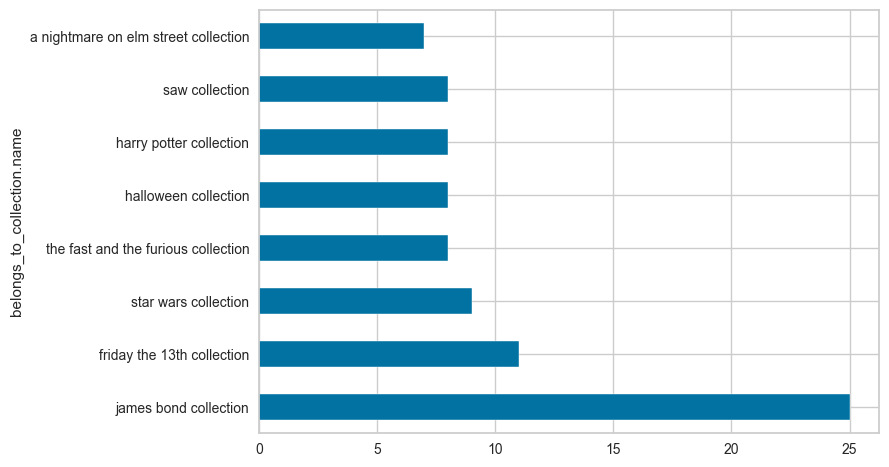

In [1147]:
df['belongs_to_collection.name'].value_counts()
df['belongs_to_collection.name'].value_counts().head(8).plot(kind='barh')
plt.show()

df['collection'] = df['belongs_to_collection.name'].notna()

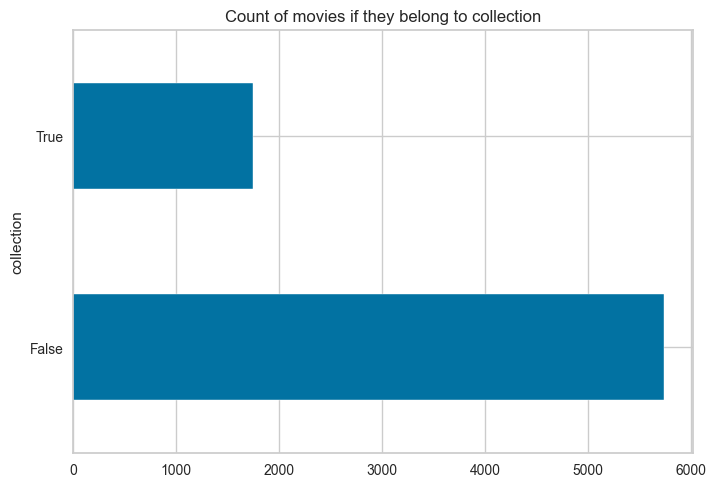

In [1148]:
df['collection'].value_counts()
df['collection'].value_counts().plot(kind='barh')
plt.title('Count of movies if they belong to collection')

plt.show()

I need to shift data in adjusted_ROI for building boxplots, because it has negative values. Also we will add 1 in np.log(df["award_points"] + 1) to avoid dividing on zero

In [1149]:
# Find the minimum value in the adjusted_ROI column
min_value = df['adjusted_ROI'].min()

# If the minimum value is negative, shift all the data by adding the absolute 
# value of the minimum value plus a small constant (e.g., 1)
if min_value < 0:
    shift_constant = abs(min_value) + 1 
    df['shifted_ROI'] = df['adjusted_ROI'] + shift_constant
else:
    df['shifted_ROI'] = df['adjusted_ROI']

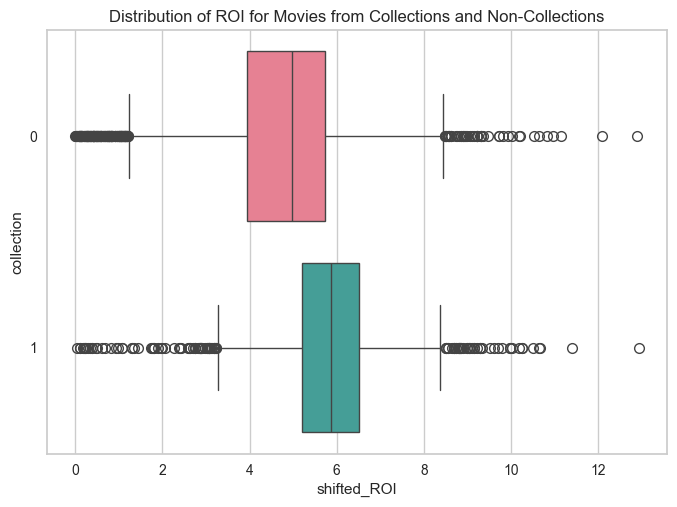

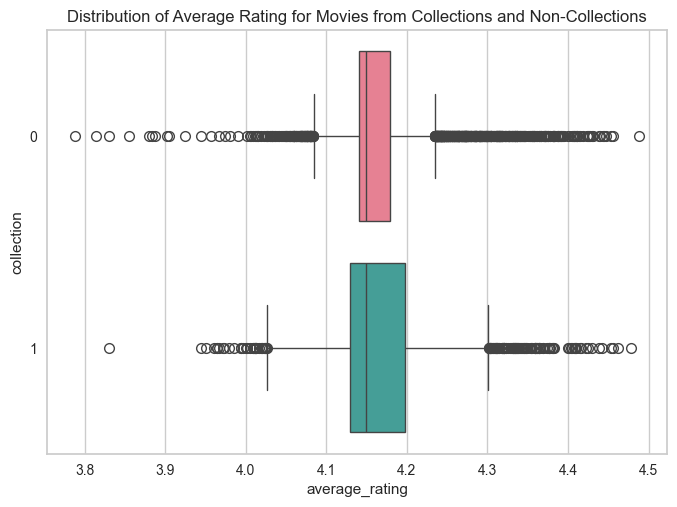

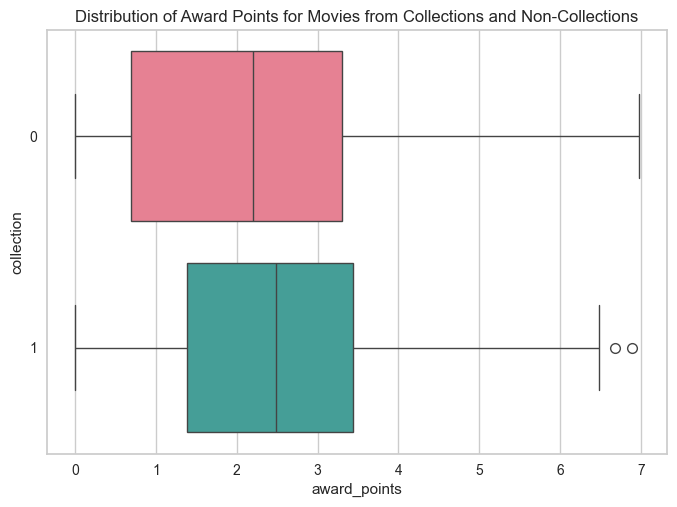

In [1150]:
isCollection_string = df['collection'].apply(lambda x: "1" if x==1 else "0")

ax = sns.boxplot(x=np.log(df['shifted_ROI']), y=isCollection_string, palette="husl", hue=isCollection_string)
plt.title('Distribution of ROI for Movies from Collections and Non-Collections')
plt.show()

ax = sns.boxplot(x=np.log(df["average_rating"]), y=isCollection_string, palette="husl", hue=isCollection_string)
plt.title('Distribution of Average Rating for Movies from Collections and Non-Collections')
plt.show()

ax = sns.boxplot(x=np.log(df["award_points"] + 1), y=isCollection_string, palette="husl", hue=isCollection_string)
plt.title('Distribution of Award Points for Movies from Collections and Non-Collections')
plt.show()

#### Runtime

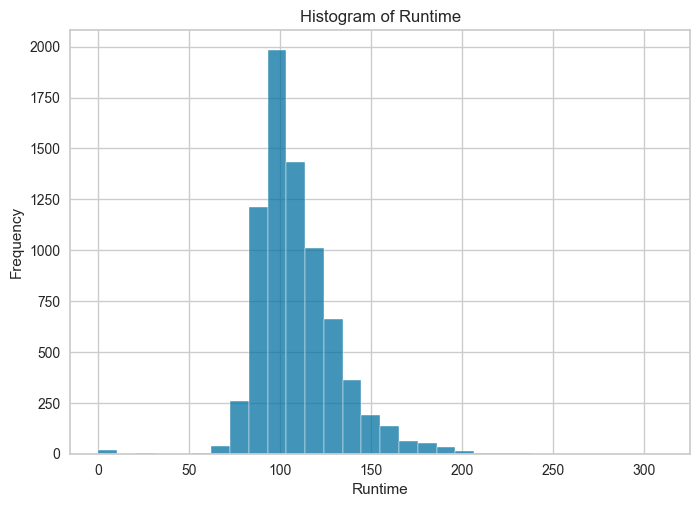

In [1151]:

sns.histplot(df['runtime'], bins=30, kde=False) 
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.title('Histogram of Runtime')
plt.show()

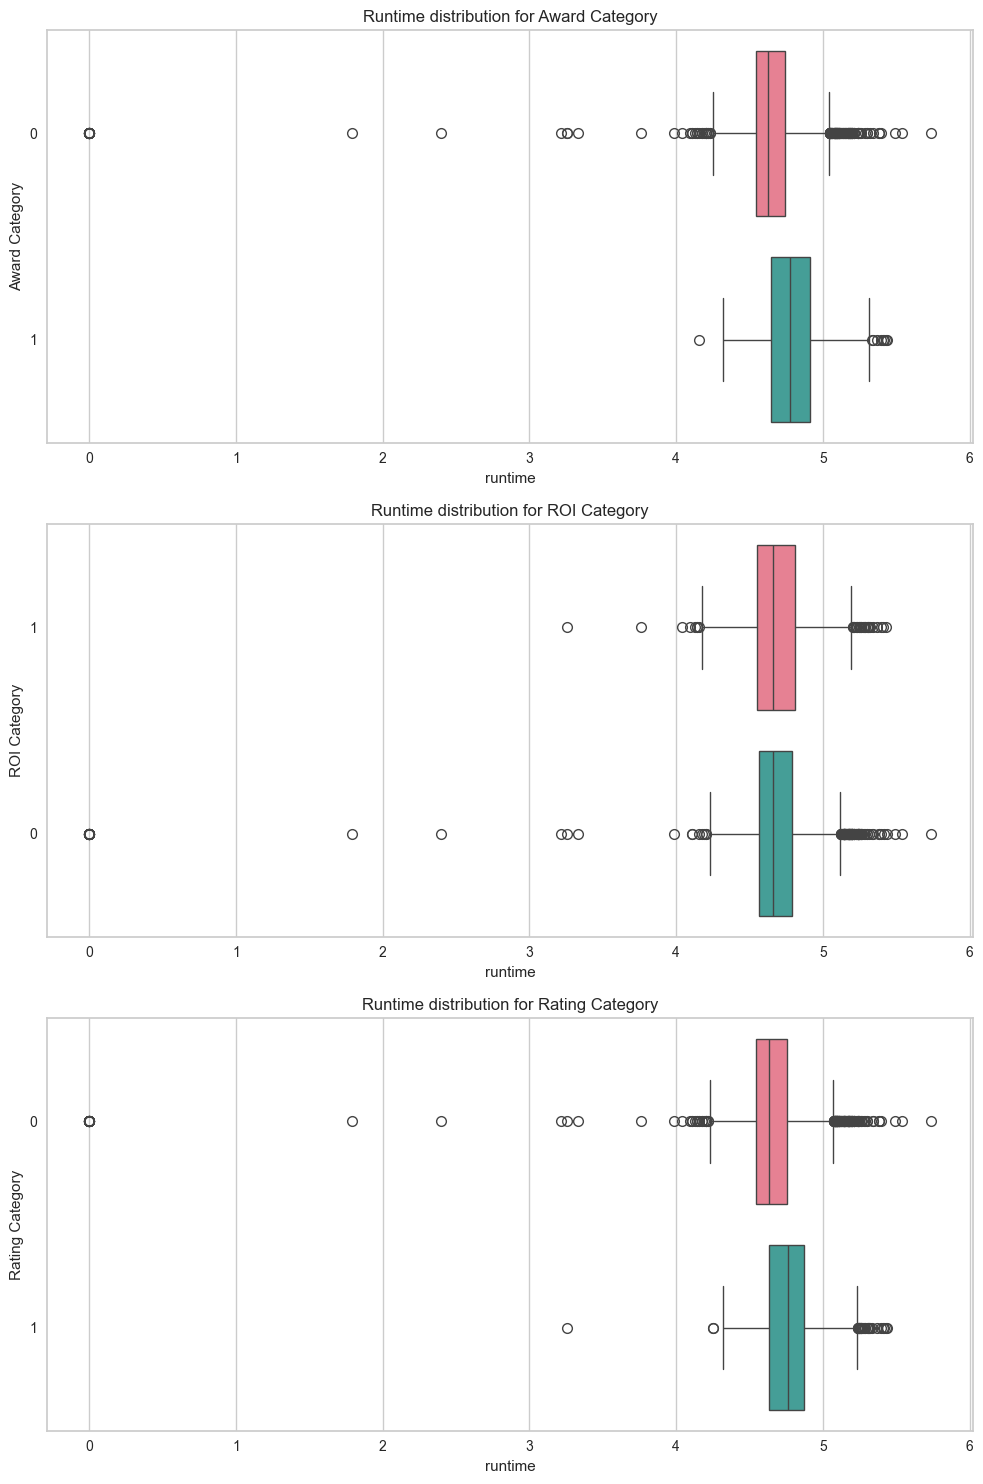

In [1152]:
award_string = df['numerical_award_category'].apply(lambda x: "1" if x==1 else "0")
ROI_string = df['numerical_ROI_category'].apply(lambda x: "1" if x==1 else "0")
rating_string = df['numerical_rating_category'].apply(lambda x: "1" if x==1 else "0")

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plotting the first boxplot for numerical_award_category
sns.boxplot(x=np.log(df["runtime"] + 1), y=award_string, ax=axs[0], palette="husl", hue=award_string)
axs[0].set_title('Runtime distribution for Award Category')
axs[0].set_ylabel('Award Category')

# Plotting the second boxplot for numerical_ROI_category
sns.boxplot(x=np.log(df["runtime"] + 1), y=ROI_string, ax=axs[1], palette="husl", hue=ROI_string)
axs[1].set_title('Runtime distribution for ROI Category')
axs[1].set_ylabel('ROI Category')

# Plotting the third boxplot for numerical_rating_category
sns.boxplot(x=np.log(df["runtime"] + 1), y=rating_string, ax=axs[2], palette="husl", hue=rating_string)
axs[2].set_title('Runtime distribution for Rating Category')
axs[2].set_ylabel('Rating Category')

plt.tight_layout() 
plt.show()


#### Original language

The most popular movie original language in the dataset is english.

The ratio of English to non-English movies is: 81.66%


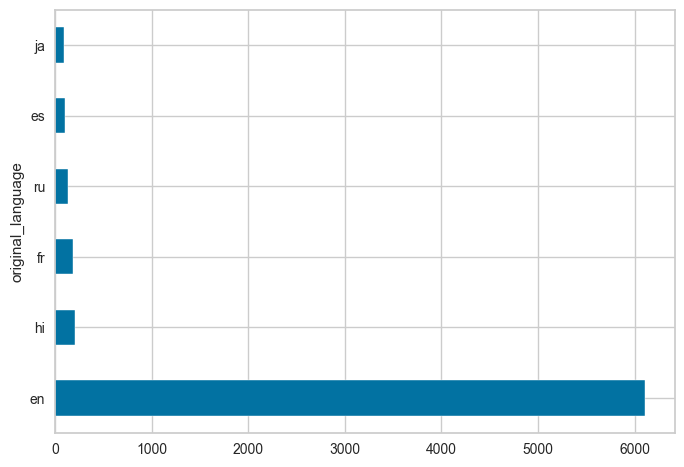

In [1153]:
english_others_ratio = (len(df[df['original_language'] =='en']) / len(df)) * 100
print(f"The ratio of English to non-English movies is: {english_others_ratio:.2f}%")

df['original_language'].value_counts().head(6).plot(kind='barh')
plt.show()

In [1154]:
df[df['adjusted_ROI'] == 0][['title', 'adjusted_revenue', "adjusted_budget", "adjusted_ROI"]]


,title,adjusted_revenue,adjusted_budget,adjusted_ROI


Let's compare success metrics for non-english and english movies

is_english
1    6112
0    1373
Name: count, dtype: int64


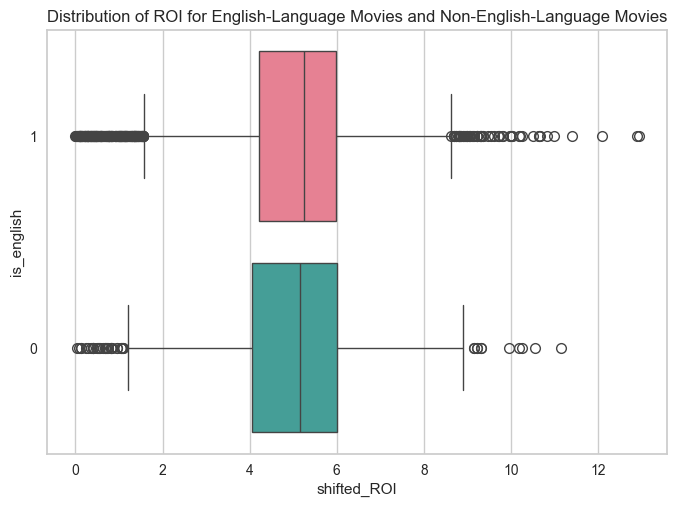

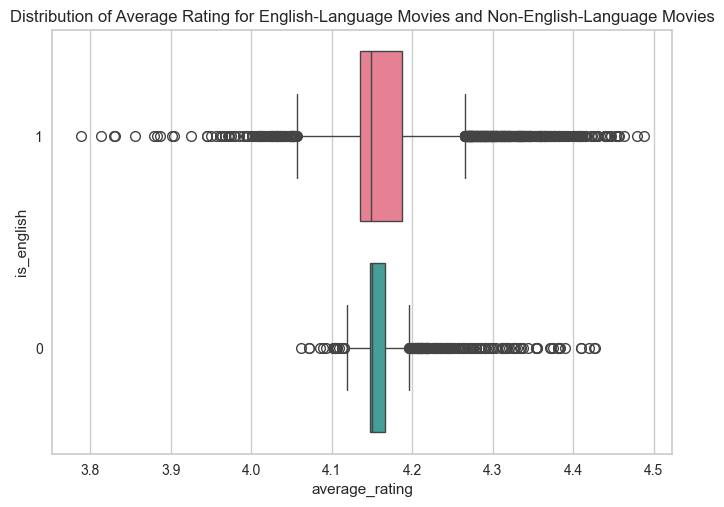

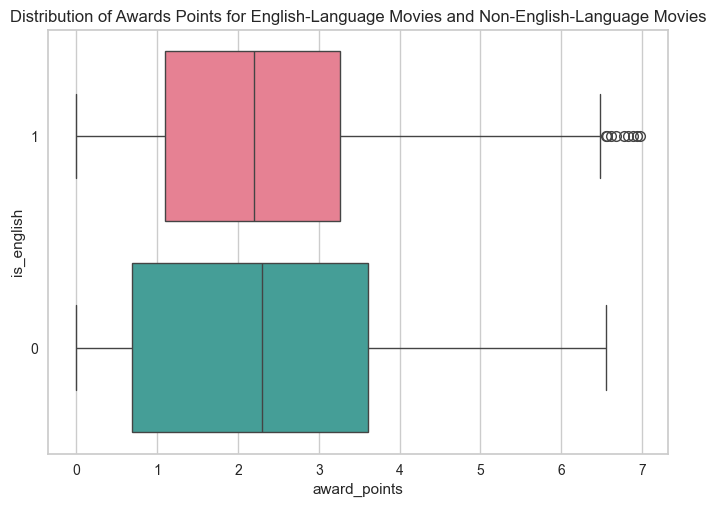

In [1155]:
df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
print(df['is_english'].value_counts())

is_english_string = df['is_english'].apply(lambda x: "1" if x==1 else "0")

ax = sns.boxplot(x=np.log(df['shifted_ROI']), y=is_english_string, palette="husl", hue=is_english_string)
plt.title('Distribution of ROI for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["average_rating"]), y=is_english_string, palette="husl", hue=is_english_string)
plt.title('Distribution of Average Rating for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["award_points"] + 1), y=is_english_string, palette="husl", hue=is_english_string)
plt.title('Distribution of Awards Points for English-Language Movies and Non-English-Language Movies')
plt.show()

**ROI**

Both English and non-English movies have a wide range of ROI values, as evidenced by the large standard deviations and the vast difference between the minimum and maximum values. The median ROI is higher for English movies compared to non-English movies, suggesting that the typical English movie has a higher ROI.

**Average Rating**

Non-English movies have a slightly higher mean and median rating compared to English movies. The range of ratings is broader for English movies. The median rating is also higher for non-English movies, indicating that non-English movies tend to receive slightly higher ratings on average.

**Award Points**

Non-English movies are associated with a bit higher mean and median number of award points, indicating a possible higher level of award recognition for non-English movies in this dataset.

#### Title, overview, tagline and plot

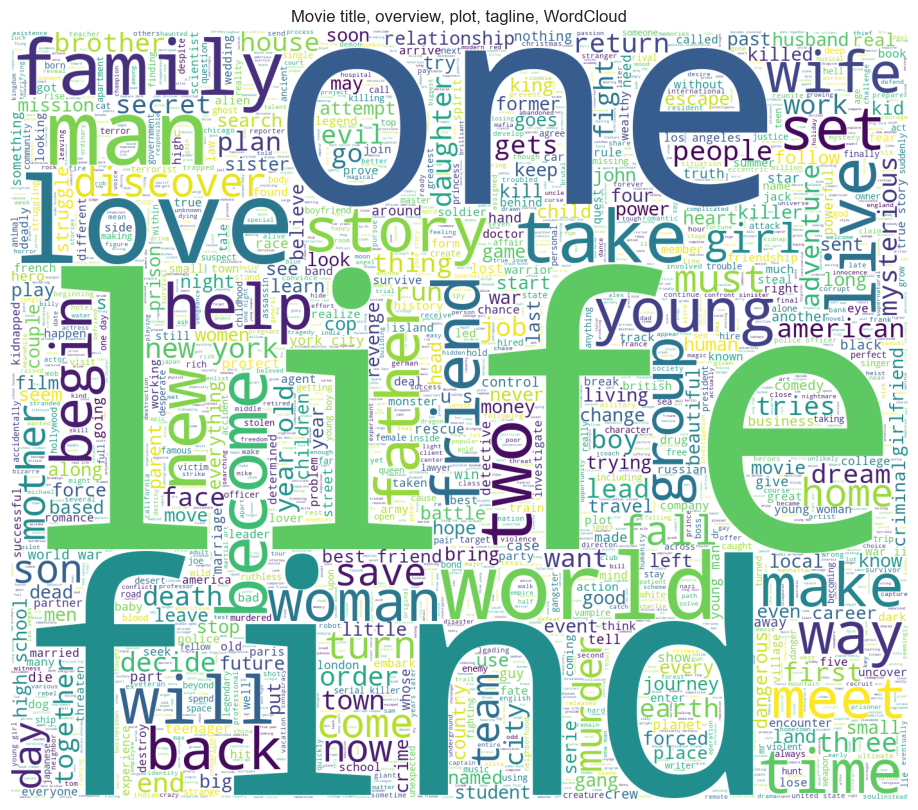

In [1156]:
text_columns = ['title', 'overview', 'plot', 'tagline']
text_data= df[text_columns].apply(lambda x: ' '.join(x), axis=1) 

text = ' '.join(text_data.astype(str))
plt.subplots(figsize=(16,10))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          max_words=10000,
                          width=1400,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('Movie title, overview, plot, tagline, WordCloud')
plt.axis('off')
plt.show()

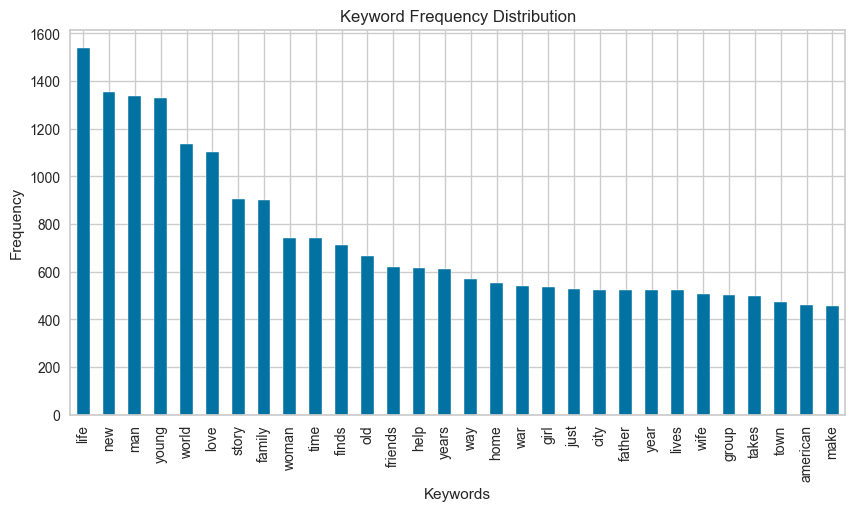

In [1157]:

vectorizer = TfidfVectorizer(max_features=300, stop_words='english') 
tfidf_matrix = vectorizer.fit_transform(text_data)  

keywords = vectorizer.get_feature_names_out()  # Get the keywords
binary_features = (tfidf_matrix > 0).astype(int)  

binary_features_df = pd.DataFrame(binary_features.toarray(), columns=keywords)  
keyword_frequencies = binary_features_df.sum(axis=0)  # Sum each column to get keyword frequencies

keyword_frequencies.sort_values(ascending=False).head(30).plot(kind='bar', figsize=(10, 5))
plt.title('Keyword Frequency Distribution')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.show()

#### Time

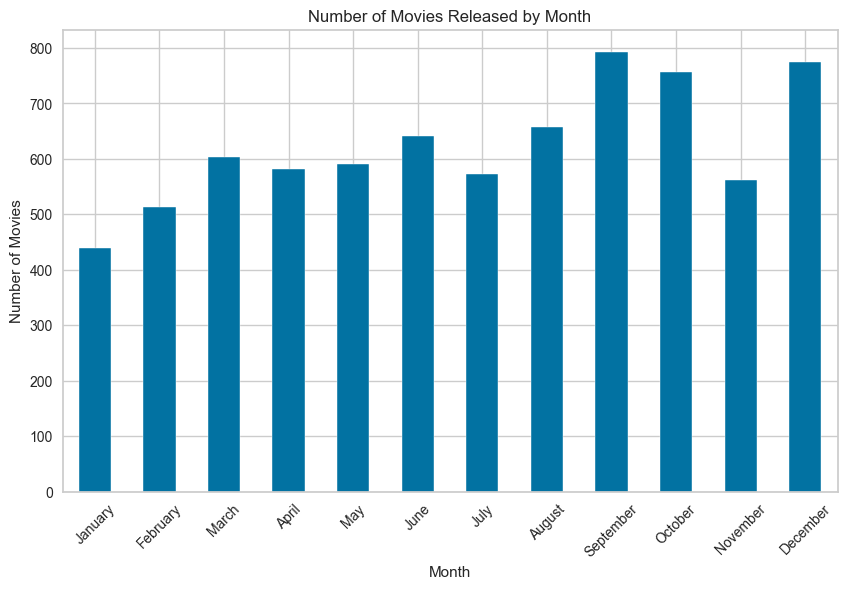

In [1158]:
month_counts = df['release_month'].value_counts().sort_index()
month_counts.plot(kind='bar', figsize=(10,6))

plt.title('Number of Movies Released by Month')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.xticks(ticks=range(12), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.show()

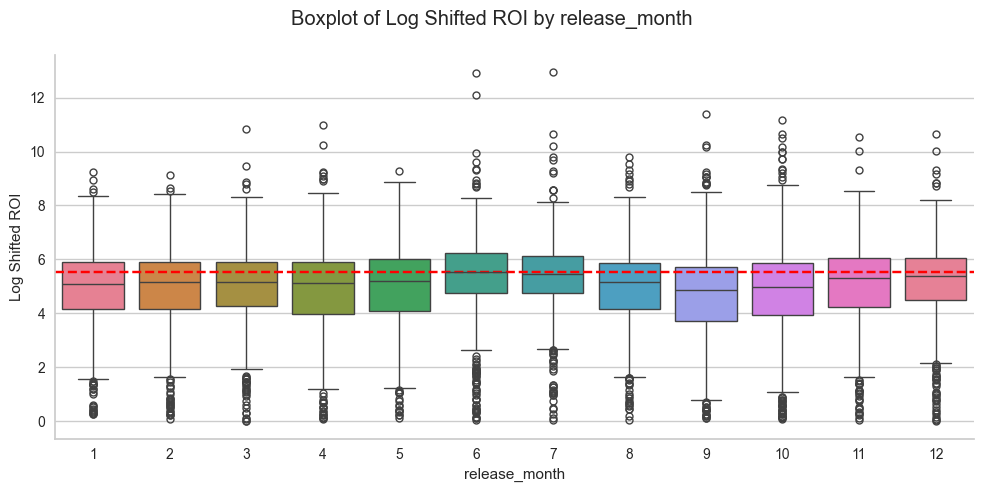

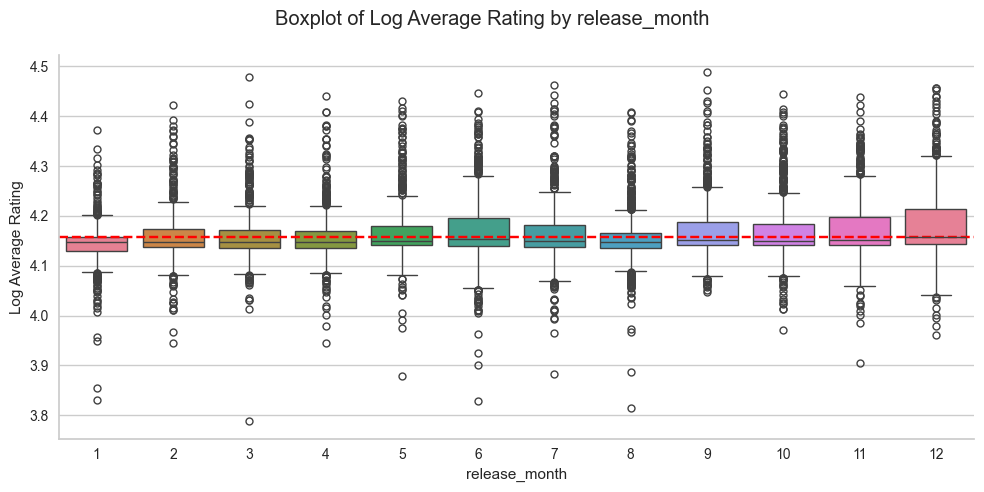

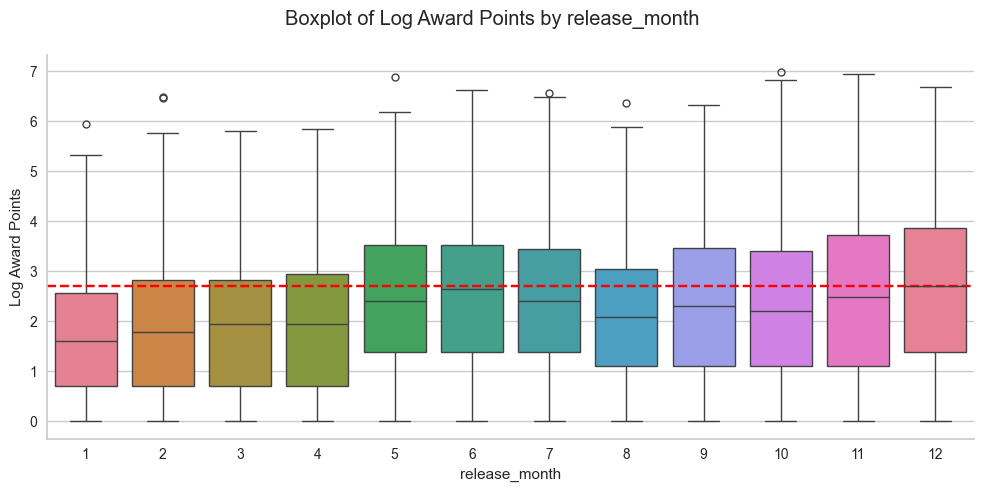

In [1159]:
def create_boxplot(data, variable, ylabel, group_column):
    g = sns.catplot(x=group_column, y=variable, kind='box', data=data, height=5, aspect=2, palette='husl', hue='release_month', legend=False)

    g.set_axis_labels(f'{group_column}', ylabel)
    g.fig.suptitle(f'Boxplot of {ylabel} by {group_column}')

    # Calculate the median values for each month
    medians = data.groupby(group_column)[variable].median()

    # Find the highest median value
    highest_median = medians.max()

    g.ax.axhline(y=highest_median, color='red', linestyle='--')

    plt.tight_layout() 
    plt.show()

df['log_adjusted_ROI'] = np.log(df['shifted_ROI'])
df['log_average_rating'] = np.log(df['average_rating'])
df['log_award_points'] = np.log(df['award_points'] + 1)

create_boxplot(df, 'log_adjusted_ROI', 'Log Shifted ROI', 'release_month')
create_boxplot(df, 'log_average_rating', 'Log Average Rating', 'release_month')
create_boxplot(df, 'log_award_points', 'Log Award Points', 'release_month')


#### ROI (Return On Investment):

- The highest median ROI is observed in the month of June, followed by July, December, and November.
- The lowest median ROI is seen in the month of September, followed by October, January, and August.
- There's a significant increase in median ROI starting from May, peaking in June, and then gradually decreasing, but remaining relatively high through July, November, and December.

#### Rating:

- The highest median rating is observed in December, with a noticeable drop in other months.
- The median rating values are fairly consistent across other months, with minor fluctuations.

#### Awards:

- The highest median awards are observed in December, followed by June.
- There's a noticeable increase in median awards starting from May, peaking in June and December.
- The lowest median awards are observed in January and February.

Based on these observations, a possible way to create a 'seasons' feature could be as follows:

* Winter: January, and February - These months show a peak in ratings and awards, and a trough in ROI (except December).
* Spring: March and April - These months show a moderate level in all three labels.
* Summer: May, June, and July - These months show a peak in ROI and awards.
* Fall: August, September, October, and November - These months show a trough in ROI and a moderate level in ratings and awards, with a spike in ROI in November.

In our dataset, we observed some interesting trends related to the month of December. Specifically, December showed the highest median rating and the highest median number of awards among all months. Additionally, the Return on Investment (ROI) in December was also relatively high, being one of the top performing months.

These trends suggest that December is a special month when it comes to movie performance metrics. One possible explanation for this could be the holiday season. December is a month full of holidays, including Christmas and New Year's Eve, which could lead to higher movie attendance and potentially more awards and higher ratings for movies released during this time.

Text(0.5, 1.0, 'Boxplot of log ROI by seasons')

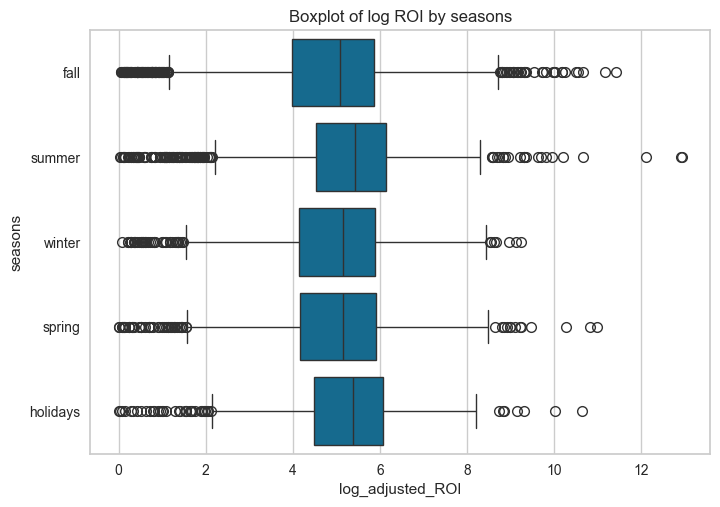

In [1160]:
def get_season(month):
    if month in [1, 2]:
        return 'winter'
    elif month == 12:
        return 'holidays'
    elif month in [3, 4]:
        return 'spring'
    elif month in [5, 6, 7]:
        return 'summer'
    else:
        return 'fall'

df['seasons'] = df['release_month'].apply(get_season)

ax = sns.boxplot(x=(df["log_adjusted_ROI"]), y=df['seasons'])
plt.title(f'Boxplot of log ROI by seasons')


Text(0.5, 1.0, 'Boxplot of log Average Raiting by seasons')

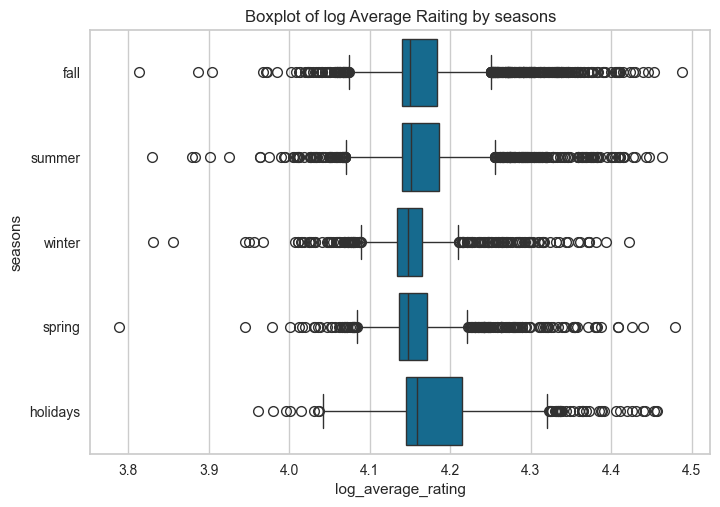

In [1161]:
ax = sns.boxplot(x=(df["log_average_rating"]), y=df['seasons'])
plt.title(f'Boxplot of log Average Raiting by seasons')


Text(0.5, 1.0, 'Boxplot of log Award Points by seasons')

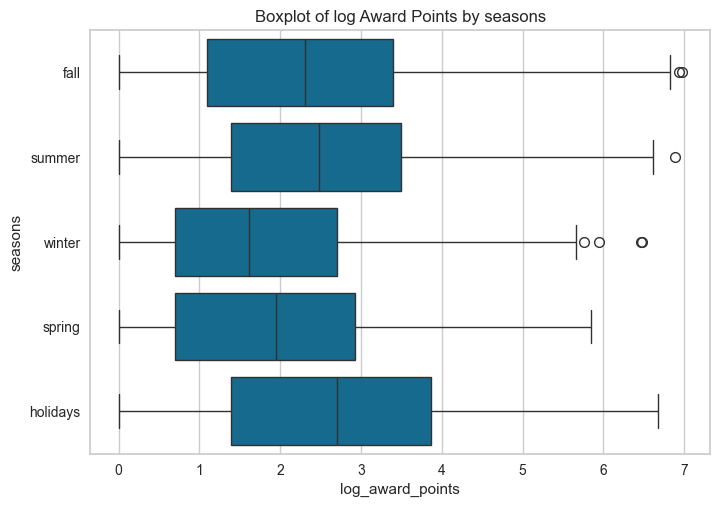

In [1162]:

ax = sns.boxplot(x=(df["log_award_points"]), y=df['seasons'])
plt.title(f'Boxplot of log Award Points by seasons')

In [1163]:
seasons_dummies = df['seasons'].str.get_dummies(sep=',')
df = pd.concat([df, seasons_dummies], axis=1)


#### Genres

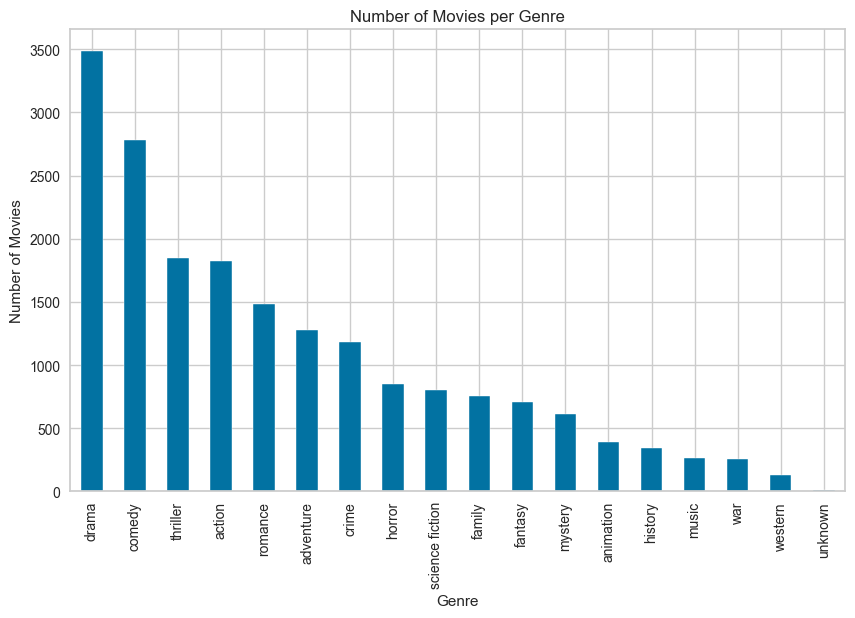

In [1164]:
genre_list = df['genres'].str.split(',', expand=True).stack()
genre_counts = genre_list.value_counts()
genre_counts.plot(kind='bar', figsize=(10,6))

plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

plt.show()


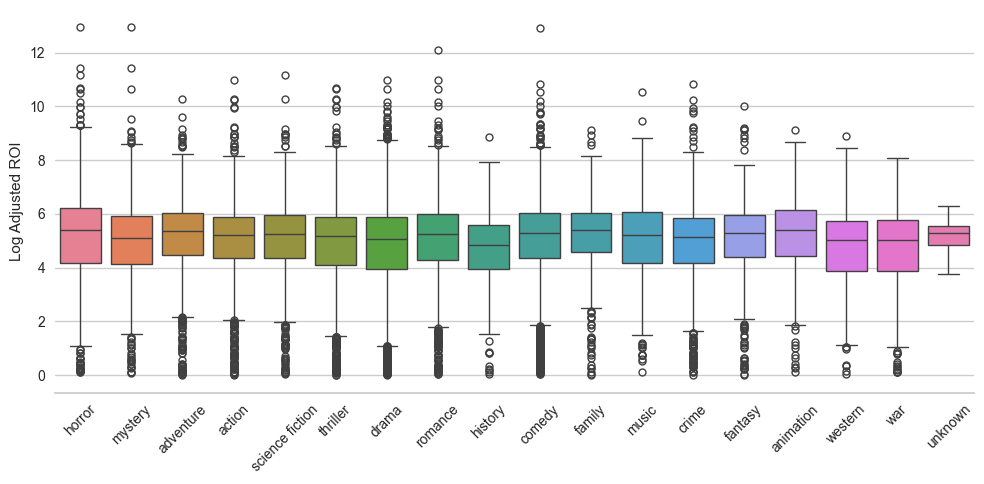

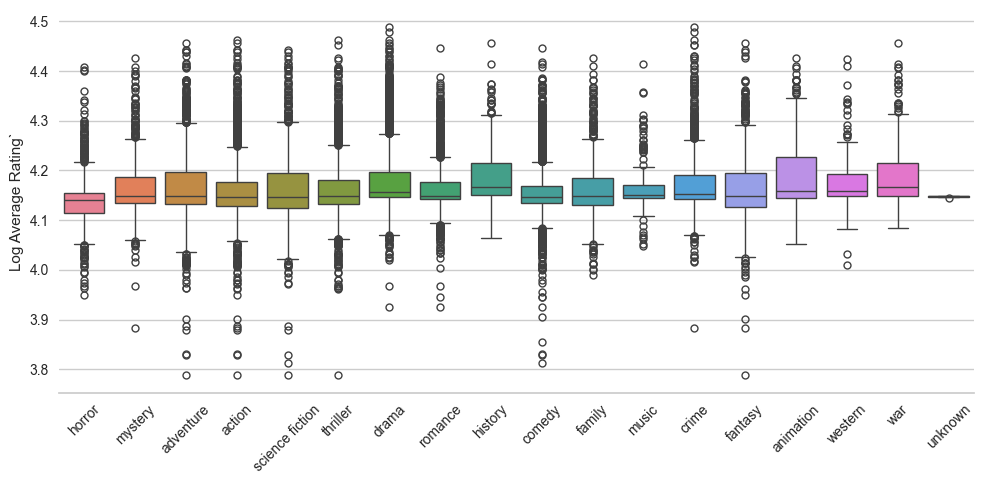

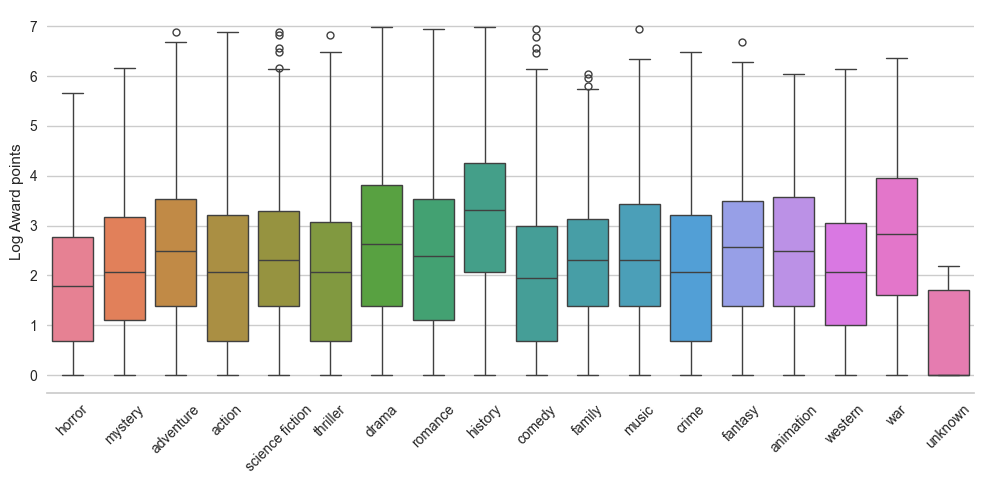

In [1165]:
genre_list = df['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('genre')
df_genre_split = df.join(genre_list).reset_index(drop=True)
g = sns.catplot(x="genre", y='log_adjusted_ROI', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="genre", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Adjusted ROI")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()

g = sns.catplot(x="genre", y='log_average_rating', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="genre", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Average Rating`")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()


g = sns.catplot(x="genre", y='log_award_points', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="genre", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Award points")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()





#### High Performing Genres (across all metrics):

- Animation: Exhibits a higher median ROI, a relatively higher median rating, and a good median awards count.
- Family: Similar to Animation, Family genre also has a higher median ROI and a decent median awards count.
- Horror: Although horror has a lower median rating, it has a high median ROI and a lower median awards count, indicating it might be commercially successful but not critically acclaimed.

#### Critically Acclaimed Genres:

- History: Despite having the lowest median ROI, this genre has the highest median awards count and a high median rating, indicating critical acclaim.
- Drama: Drama also has a high median awards count and a relatively higher median rating despite a moderate median ROI.
- War: War genre has a high median awards count and a high median rating with a moderate median ROI.

#### Moderate Performing Genres:

Adventure, Comedy, Fantasy, Romance, Science Fiction, and Thriller: These genres exhibit a moderate performance across all three metrics (ROI, rating, and awards). They can be considered separately or grouped together under a "Moderate Performing" category depending on the goal of your analysis.

#### Low Performing or Less Represented Genres:

Crime, Western, and Unknown: These genres have lower median values across all three metrics, and the 'unknown' genre especially has the lowest representation. They might be grouped together as "Others" or even ignored depending on the context and the goal of the analysis.
Others:

Genres like Music, Mystery, and Action have mixed performance across the three metrics and could be grouped together under an "Others" category.

Let's set Adventure, Comedy, Fantasy, Romance, Science Fiction, and Thriller as a separate category "moderate performing". Music, Mystery, Action, Crime, Western, and Unknown as others and then create dummies from genres column

In [1166]:
def replace_genre(genre_string):
    genre_string = genre_string.replace('adventure', 'moderate performing')
    genre_string = genre_string.replace('comedy','moderate performing')
    genre_string = genre_string.replace('fantasy', 'moderate performing')
    genre_string = genre_string.replace('romance', 'moderate performing')
    genre_string = genre_string.replace('science fiction', 'moderate performing')
    genre_string = genre_string.replace('thriller', 'moderate performing')
    genre_string = genre_string.replace('crime', 'others')
    genre_string = genre_string.replace('western', 'others')
    genre_string = genre_string.replace('unknown', 'others')
    genre_string = genre_string.replace('music', 'others')
    genre_string = genre_string.replace('mystery', 'others')
    genre_string = genre_string.replace('action', 'others')
    return genre_string

df['genres'] = df['genres'].apply(replace_genre)

genre_dummies = df['genres'].str.get_dummies(sep=',')
df = pd.concat([df, genre_dummies], axis=1)

#### Rated

In [1167]:
df['rated'].value_counts()

rated
r          2904
pg-13      1760
unrated    1250
pg         1106
g           221
other       209
nc-17        35
Name: count, dtype: int64

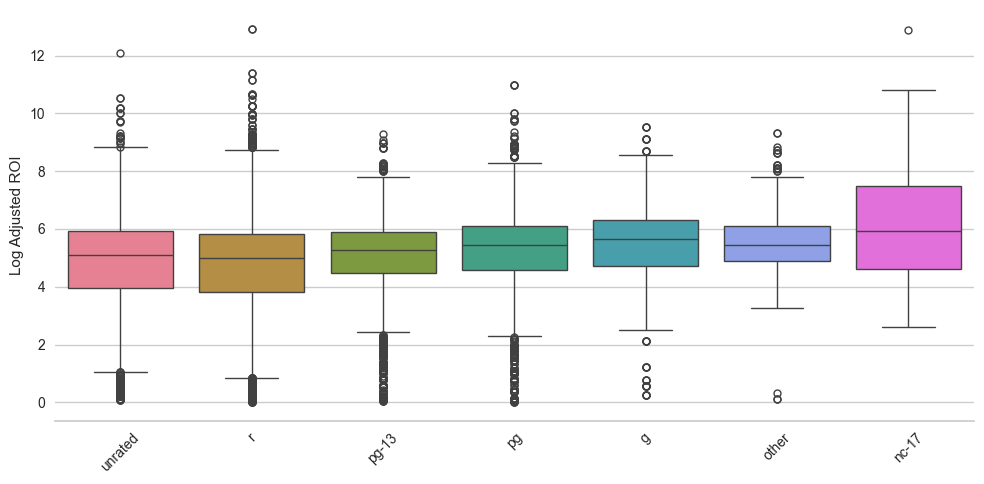

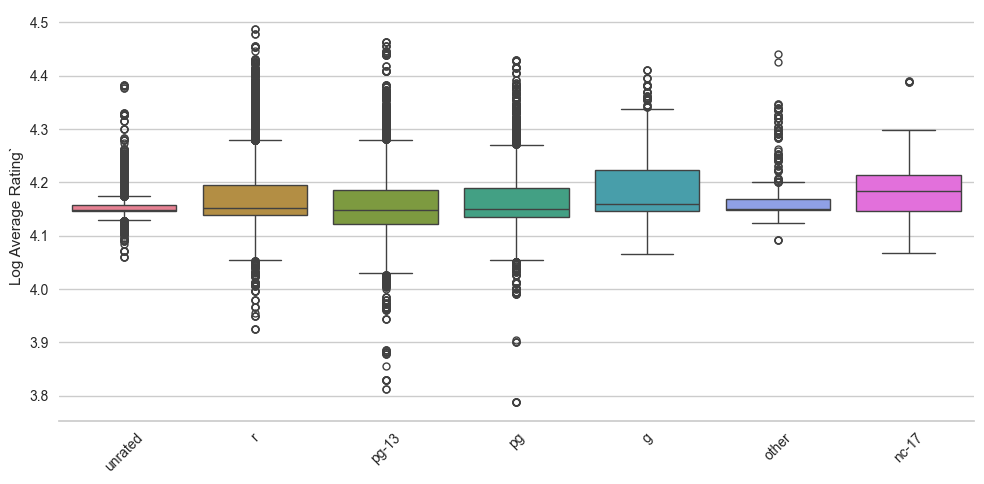

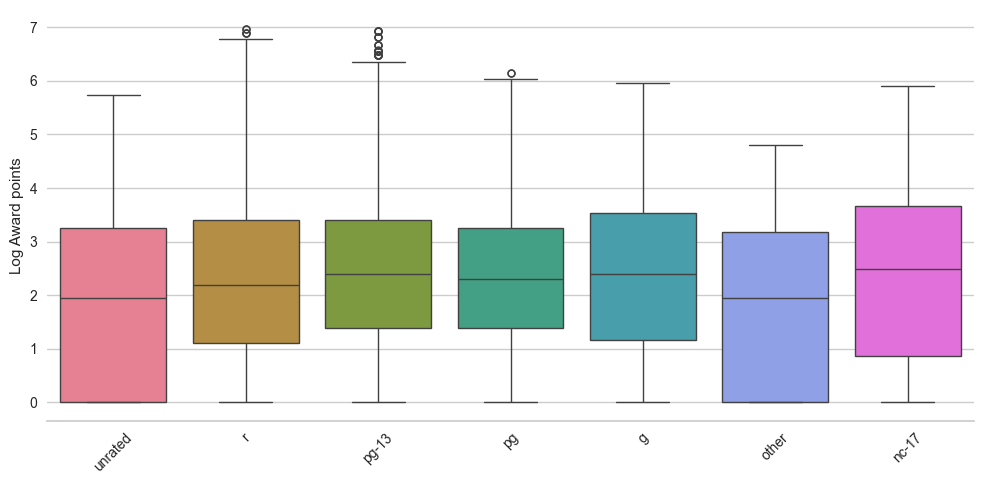

In [1168]:
g = sns.catplot(x="rated", y='log_adjusted_ROI', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="rated", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Adjusted ROI")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()

g = sns.catplot(x="rated", y='log_average_rating', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="rated", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Average Rating`")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()


g = sns.catplot(x="rated", y='log_award_points', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="rated", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Award points")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()



films rated NC-17 have a higher median ROI compared to other ratings, while films rated G have a higher median in awards and a competitive median ROI.
On the other hand, films rated R have the lowest median ROI and a relatively low median in awards.

If some ratings like NC-17 or Unrated have significantly fewer entries compared to others, however, since NC-17 has a high median ROI, I would leave it as a separate rating, but I will combine Unrated and Others



In [1169]:
df['rated'] = df['rated'].replace('unrated', 'others')

#### List colums: spoken_languages, genres, production_companies, production_countries



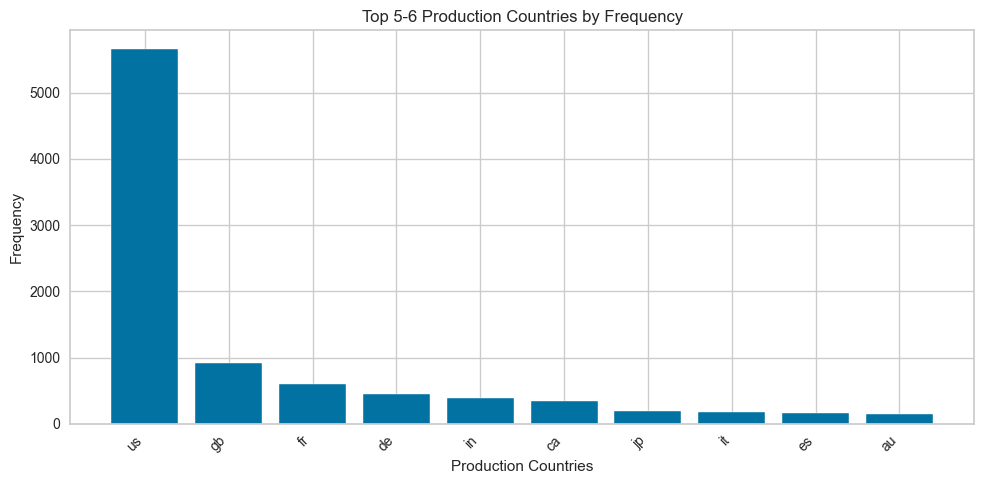

In [1170]:
production_c_df = df.copy()
production_c_df['production_countries'] = production_c_df['production_countries'].str.split(',')
genre_counter = Counter(genre for genre_list in production_c_df['production_countries'].dropna() for genre in genre_list)
genre_frequencies = pd.DataFrame(genre_counter.items(), columns=['production_countries', 'frequency'])

genre_frequencies = genre_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
genre_frequencies

top_countries = genre_frequencies.head(10)


plt.figure(figsize=(10, 5))
plt.bar(top_countries['production_countries'], top_countries['frequency'])
plt.xlabel('Production Countries')
plt.ylabel('Frequency')
plt.title('Top 5-6 Production Countries by Frequency')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 
plt.show()

The majority of movies in the dataset are produced in the US

In [1171]:
empty_strings = df['production_companies'].value_counts().get('', 0)
print(f"Number of empty strings in column_name: {empty_strings}")

df['production_companies'] = df['production_companies'].replace('', 'no_company')


Number of empty strings in column_name: 0


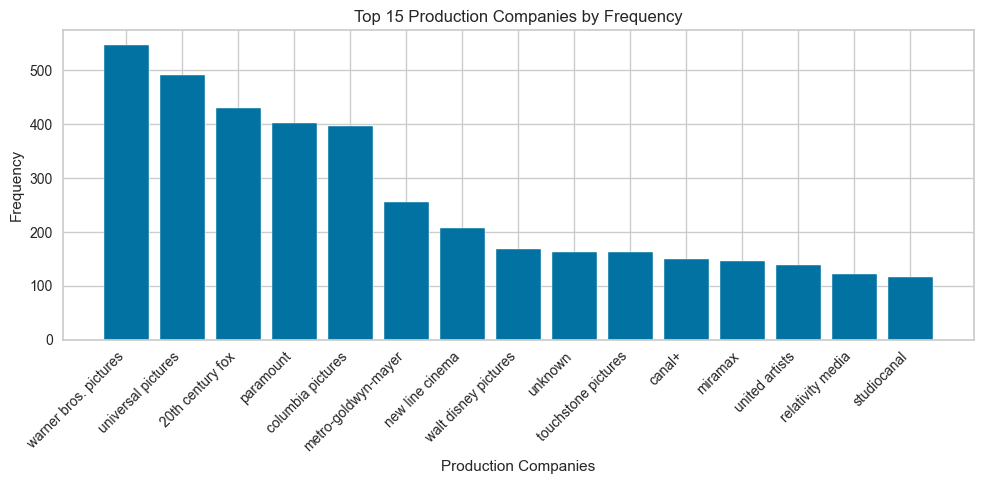

In [1172]:
production_c_df = df.copy()
production_c_df['production_companies'] = production_c_df['production_companies'].str.split(',')
genre_counter = Counter(genre for genre_list in production_c_df['production_companies'].dropna() for genre in genre_list)
production_companies = pd.DataFrame(genre_counter.items(), columns=['production_companies', 'frequency'])

production_companies = production_companies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
production_companies.head(10)

top_companies= production_companies.head(15)

plt.figure(figsize=(10, 5))
plt.bar(top_companies['production_companies'], top_companies['frequency'])
plt.xlabel('Production Companies')
plt.ylabel('Frequency')
plt.title('Top 15 Production Companies by Frequency')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()


In [1173]:
lang_df = df.copy()
lang_df['spoken_languages'] = lang_df['spoken_languages'].str.split(',')
genre_counter = Counter(genre for genre_list in lang_df['spoken_languages'].dropna() for genre in genre_list)
genre_frequencies = pd.DataFrame(genre_counter.items(), columns=['spoken_languages', 'frequency'])

genre_frequencies = genre_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
genre_frequencies.head(10)

,spoken_languages,frequency
0,en,6349
1,fr,687
2,es,608
3,de,380
4,ru,372
5,it,360
6,hi,242
7,ja,235
8,zh,178
9,ar,118


And again the majority of movies in the datase uses english as spoken language

Let's add counts of languages, companies and countries as a new features

In [1174]:
df['num_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x.split(',')) if x else 0)
df['num_production_companies'] = df['production_companies'].apply(lambda x: len(x.split(',')) if x else 0)
df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x.split(',')) if x else 0)
df[['num_spoken_languages', 'num_production_companies', 'num_production_countries']].describe()

,num_spoken_languages,num_production_companies,num_production_countries
count,7485.00,7485.00,7485.00
mean,1.46,3.15,1.41
std,0.91,2.28,0.84
min,1.00,1.00,1.00
25%,1.00,2.00,1.00
50%,1.00,3.00,1.00
75%,2.00,4.00,2.00
max,11.00,30.00,12.00


And add is_foreign for those countries that are not US:

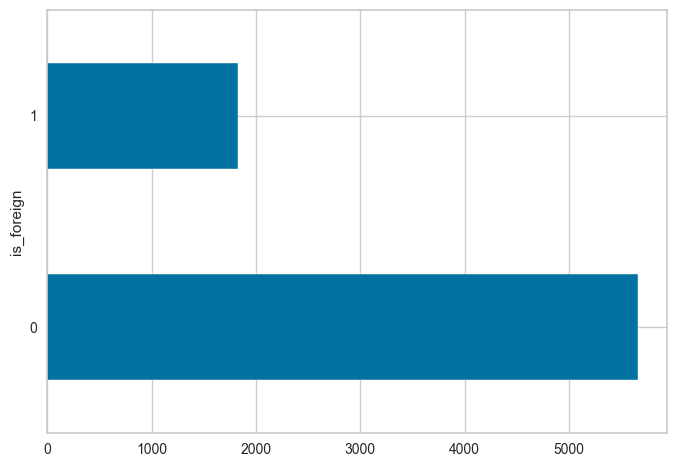

In [1175]:
df['is_foreign'] = df['production_countries'].apply(lambda x: 1 if 'us' not in x else 0)
df['is_foreign'].value_counts()
df['is_foreign'].value_counts().plot(kind='barh')
plt.show()

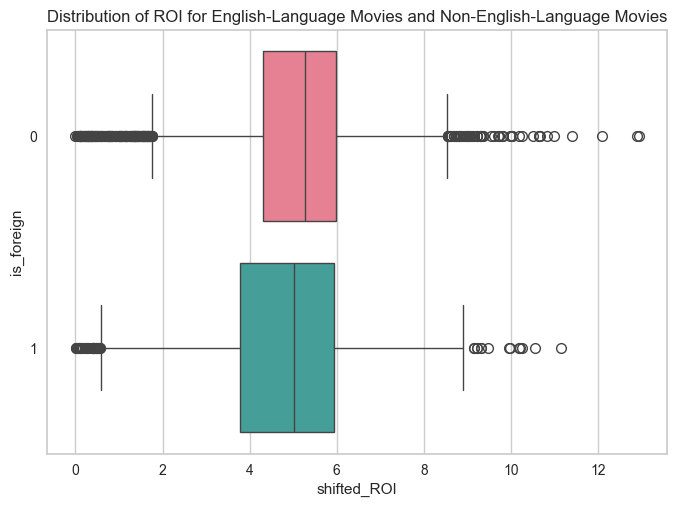

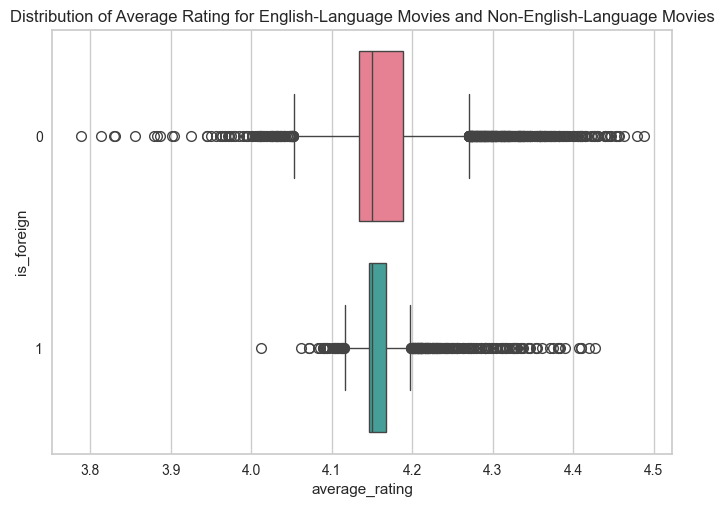

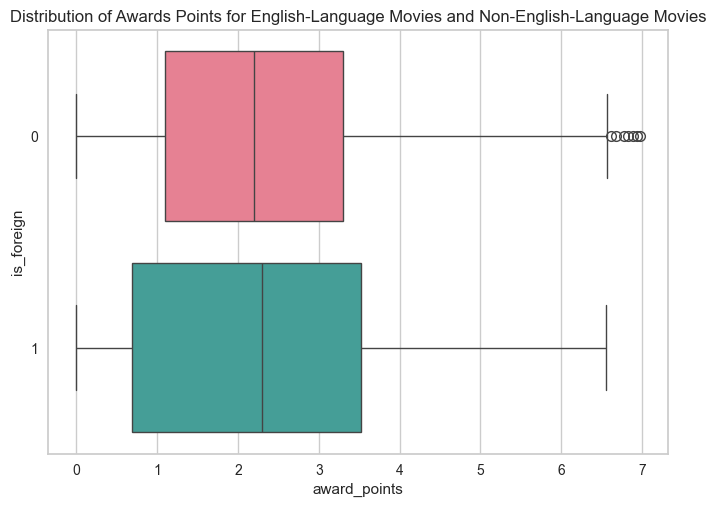

In [1176]:
is_foreign_string = df['is_foreign'].apply(lambda x: "1" if x==1 else "0")

ax = sns.boxplot(x=np.log(df['shifted_ROI']), y=is_foreign_string, palette="husl", hue=is_foreign_string)
plt.title('Distribution of ROI for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["average_rating"]), y=is_foreign_string, palette="husl", hue=is_foreign_string)
plt.title('Distribution of Average Rating for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["award_points"] + 1), y=is_foreign_string, palette="husl", hue=is_foreign_string)
plt.title('Distribution of Awards Points for English-Language Movies and Non-English-Language Movies')
plt.show()

Domestic movies (indicated by is_foreign value 0) tend to have a higher median ROI compared to foreign movies. the is_foreign classification does not significantly impact the rating a movie receives and foreign movies have a slightly higher median award count of 9 compared to domestic movies.

The is_foreign feature can be utilized to understand or predict the financial success and award potential of movies, as there is a slight variation in ROI and awards count based on the domestic or foreign classification. However, its impact on ratings appears to be negligible.

#### Crew

In [1177]:
df['director_popularity'] = 0
df['director_popularity_list'] = df.apply(lambda x: [], axis=1)
df['director'] = df.apply(lambda x: [], axis=1)
df['writer'] = df.apply(lambda x: [], axis=1)
df['writer_popularity_list'] = df.apply(lambda x: [], axis=1)
df['producer'] = df.apply(lambda x: [], axis=1)
df['producer_popularity_list'] = df.apply(lambda x: [], axis=1)
df['writer_popularity'] = 0
df['producer_popularity'] = 0
df['average_crew_popularity'] = 0
df['number_crew_members'] = 0

def update_popularity(row):
    director = []
    director_popularity_list = []
    writer = []
    writer_popularity_list = []
    producer = []
    producer_popularity_list = []
    director_popularity = 0
    writer_popularity = 0
    producer_popularity = 0
    total_popularity = 0
    num_directors = 0
    num_writers = 0
    num_producers = 0
    num_crew_members = len(row['crew'])
    
    for member in row['crew']:
        job = member.get('job', '')
        name = member.get('name', '')
        popularity = member.get('popularity', 0)
        total_popularity += popularity
        
        if job == 'director':
            director.append(name)
            director_popularity += popularity
            director_popularity_list.append(popularity)
            num_directors += 1
        elif job in ['writer', 'screenplay']:
            writer.append(name)
            writer_popularity += popularity
            writer_popularity_list.append(popularity)
            num_writers += 1
        elif job == 'producer':
            producer.append(name)
            producer_popularity += popularity
            producer_popularity_list.append(popularity)
            num_producers += 1
    
    # Average the popularity for directors, writers, and producers if there are multiple
    director_popularity /= max(num_directors, 1)
    writer_popularity /= max(num_writers, 1)
    producer_popularity /= max(num_producers, 1)
    
    # Compute the average popularity for all crew members
    average_crew_popularity = total_popularity / max(num_crew_members, 1)
    
    return pd.Series([director, director_popularity, director_popularity_list, writer, writer_popularity_list,writer_popularity,producer,  producer_popularity_list, producer_popularity, average_crew_popularity, num_crew_members])

df[['director', 'director_popularity', 'director_popularity_list', 'writer', 'writer_popularity_list', 'writer_popularity', 'producer', 'producer_popularity_list','producer_popularity', 'average_crew_popularity', 'number_crew_members']] = df.apply(update_popularity, axis=1)

def calculate_top_individuals(role_column, popularity_column):
    rows_list = []
    for index, row in df.iterrows():
        for individual, popularity in zip(row[role_column], row[popularity_column]):
            rows_list.append({role_column: individual, 'popularity': popularity})
    role_df = pd.DataFrame(rows_list)
    role_popularity = role_df.groupby(role_column)['popularity'].agg(['mean', 'count'])
    role_popularity = role_popularity.sort_values(by='mean', ascending=False)

    return role_popularity

top_popularity_directors = calculate_top_individuals('director', 'director_popularity_list')
top_popularity_writers = calculate_top_individuals('writer', 'writer_popularity_list')
top_popularity_producers = calculate_top_individuals('producer', 'producer_popularity_list')

top_fr_directors =  top_popularity_directors.sort_values(by='count', ascending=False)
top_fr_writers =  top_popularity_writers.sort_values(by='count', ascending=False)
top_fr_producers =  top_popularity_producers.sort_values(by='count', ascending=False)


In [1178]:
top_popularity_directors_reset = top_popularity_directors.head(10).reset_index()
top_popularity_writers_reset = top_popularity_writers.head(10).reset_index()
top_popularity_producers_reset = top_popularity_producers.head(10).reset_index()
top_fr_directors_reset = top_fr_directors.head(10).reset_index()
top_fr_writers_reset = top_fr_writers.head(10).reset_index()
top_fr_producers_reset = top_fr_producers.head(10).reset_index()

combined_df = pd.concat([
    top_popularity_directors_reset, top_fr_directors_reset, top_popularity_writers_reset,  top_fr_writers_reset,
    top_popularity_producers_reset, top_fr_producers_reset
], axis=1)

combined_df.columns = [
    'Top Popularity Directors', 'Popularity','Frequency',
    'Top Frequency Directors', 'Popularity', 'Frequency',
    'Top Popularity Writers', 'Popularity','Frequency',
    'Top Frequency Writers', 'Frequency','Frequency',
    'Top Popularity Producers', 'Popularity','Frequency',
    'Top Frequency Producers', 'Frequency','Frequency',
]

combined_df.style


,Top Popularity Directors,Popularity,Frequency,Top Frequency Directors,Popularity,Frequency,Top Popularity Writers,Popularity,Frequency,Top Frequency Writers,Frequency,Frequency,Top Popularity Producers,Popularity,Frequency,Top Frequency Producers,Frequency,Frequency
0,morgan freeman,146.531000,1,steven spielberg,32.050581,31,jackie chan,103.906000,1,luc besson,17.033125,32,jackie chan,104.768500,4,joel silver,3.668102,59
1,jackie chan,116.503500,2,clint eastwood,43.069097,31,owen wilson,76.115000,3,woody allen,17.003571,28,nicolas cage,103.165000,7,scott rudin,3.447224,58
2,eddie murphy,73.590000,1,woody allen,17.003571,28,matt damon,74.372000,2,david koepp,8.777591,22,morgan freeman,88.560000,1,brian grazer,5.178204,54
3,tinto brass,69.549000,2,ridley scott,12.853739,23,eddie murphy,73.590000,2,oliver stone,10.253682,22,anne hathaway,82.670000,1,arnon milchan,3.510627,51
4,mel gibson,68.019500,4,ron howard,20.948955,22,tom hanks,65.519500,2,john hughes,10.187000,22,owen wilson,74.132000,1,tim bevan,3.321298,47
5,tom hanks,65.519500,2,martin scorsese,25.714818,22,steven seagal,61.663000,1,sylvester stallone,46.229100,20,benicio del toro,69.973000,1,eric fellner,4.568283,46
6,denzel washington,63.011000,2,brian de palma,8.173524,21,mel gibson,60.137000,2,ethan coen,6.393222,18,ryan reynolds,67.667000,1,neal h. moritz,4.420435,46
7,kevin costner,61.006667,3,steven soderbergh,6.844800,20,adam sandler,55.978700,10,william goldman,4.109556,18,tom hanks,66.705545,11,john davis,3.673500,44
8,keanu reeves,53.169000,1,alfred hitchcock,15.134650,20,ryan gosling,48.887000,1,akiva goldsman,5.708389,18,kevin costner,66.121615,13,jerry bruckheimer,10.777927,41
9,russell crowe,52.130000,1,oliver stone,10.254895,19,natalie portman,47.798000,2,joel coen,9.518111,18,mel gibson,63.453600,5,roger birnbaum,1.641675,40


In [1179]:
df_director = df.explode('director')

top_directors_profit = df_director.groupby(['director'])['adjusted_ROI'].max().sort_values(ascending=False).head(10)
top_directors_awards = df_director.groupby('director')['award_points'].sum().sort_values(ascending=False).head(10)
top_directors_rating = df_director.groupby('director')['average_rating'].max().sort_values(ascending=False).head(10)
print("Top 10 directors by ROI", pd.DataFrame(top_directors_profit))
print("Top 10 directors by Award Points", top_directors_awards)
print("Top 10 directors by Average Rating", top_directors_rating)



Top 10 directors by ROI                  adjusted_ROI
director                     
daniel myrick       414298.50
eduardo sánchez     414298.50
gerard damiano      399900.00
rick salomon        178631.01
oren peli            89832.93
aureliano luppi      69741.50
mel welles           69741.50
floyd mutrux         58233.33
john waters          49900.00
travis cluff         42864.41
Top 10 directors by Award Points director
steven spielberg               3676
peter jackson                  2581
martin scorsese                2351
christopher nolan              2328
quentin tarantino              2141
david fincher                  1986
alejandro gonzález iñárritu    1979
ang lee                        1863
joel coen                      1839
clint eastwood                 1643
Name: award_points, dtype: int64
Top 10 directors by Average Rating director
frank darabont         88.94
francis ford coppola   88.12
christopher nolan      86.69
peter jackson          86.18
steven spielberg     

In [1180]:
df_writer = df.explode('writer')

top_writers_profit = df_writer.groupby(['writer'])['adjusted_ROI'].max().sort_values(ascending=False).head(10)
top_writers_awards = df_writer.groupby('writer')['award_points'].sum().sort_values(ascending=False).head(10)
top_writers_rating = df_writer.groupby('writer')['average_rating'].max().sort_values(ascending=False).head(10)
print("Top 10 writers by ROI", pd.DataFrame(top_writers_profit))
print("Top 10 writers by Award Points", top_writers_awards)
print("Top 10 writers by Average Rating", top_writers_rating)

Top 10 writers by ROI                    adjusted_ROI
writer                         
eduardo sánchez       414298.50
daniel myrick         414298.50
gerard damiano        399900.00
oren peli              89832.93
edward di lorenzo      69741.50
floyd mutrux           58233.33
don simpson            58233.33
john waters            49900.00
travis cluff           42864.41
chris lofing           42864.41
Top 10 writers by Award Points writer
peter jackson        2581
fran walsh           2581
philippa boyens      2436
christopher nolan    2314
quentin tarantino    2194
ethan coen           2115
joel coen            2115
james cameron        1706
eric roth            1706
damien chazelle      1584
Name: award_points, dtype: int64
Top 10 writers by Average Rating writer
frank darabont         88.94
mario puzo             88.12
francis ford coppola   88.12
jonathan nolan         86.69
christopher nolan      86.69
peter jackson          86.18
fran walsh             86.18
philippa boyens     

In [1181]:
df_producer = df.explode('producer')

top_producers_profit = df_producer.groupby(['producer'])['adjusted_ROI'].max().sort_values(ascending=False).head(10)
top_producers_awards = df_producer.groupby('producer')['award_points'].sum().sort_values(ascending=False).head(10)
top_producers_rating = df_producer.groupby('producer')['average_rating'].max().sort_values(ascending=False).head(10)
print("Top 10 producers by ROI", pd.DataFrame(top_producers_profit))
print("Top 10 producers by Award Points", top_producers_awards)
print("Top 10 producers by Average Rating", top_producers_rating)

Top 10 producers by ROI                adjusted_ROI
producer                   
robin cowie       414298.50
gregg hale        414298.50
louis peraino     399900.00
amir zbeda         89832.93
oren peli          89832.93
jason blum         89832.93
mel welles         69741.50
roger corman       69741.50
fouad said         58233.33
john waters        49900.00
Top 10 producers by Award Points producer
scott rudin         5296
arnon milchan       3964
kathleen kennedy    3823
steven spielberg    3144
eric fellner        2946
tim bevan           2911
kevin feige         2893
peter jackson       2811
brad pitt           2754
fran walsh          2436
Name: award_points, dtype: int64
Top 10 producers by Average Rating producer
niki marvin         88.94
albert s. ruddy     88.12
lorne orleans       86.69
christopher nolan   86.69
charles roven       86.69
emma thomas         86.69
barrie m. osborne   86.18
peter jackson       86.18
fran walsh          86.18
branko lustig       86.13
Name: avera

#### Cast

In [1182]:
df['average_cast_popularity'] = 0
df['number_cast_members'] = 0
df['top_cast_popularity'] = 0

def update_cast_popularity(row):
    total_popularity = 0
    top_cast_popularity = 0
    num_cast_members = len(row['cast'])
    
    # Sort the cast members by popularity, in descending order
    sorted_cast = sorted(row['cast'], key=lambda x: x.get('popularity', 0), reverse=True)
    
    for idx, member in enumerate(sorted_cast):
        popularity = member.get('popularity', 0)
        total_popularity += popularity
    
    # Compute the average popularity for all cast members
    average_cast_popularity = total_popularity / max(num_cast_members, 1)
    
    return pd.Series([average_cast_popularity, num_cast_members])

df[['average_cast_popularity', 'number_cast_members']] = df.apply(update_cast_popularity, axis=1)
df[['average_cast_popularity', 'number_cast_members']].describe()

,average_cast_popularity,number_cast_members
count,7485.00,7485.00
mean,6.13,35.70
std,3.62,25.24
min,0.60,1.00
25%,3.56,18.00
50%,5.54,29.00
75%,7.97,46.00
max,44.34,348.00


#### Feature importance analysis

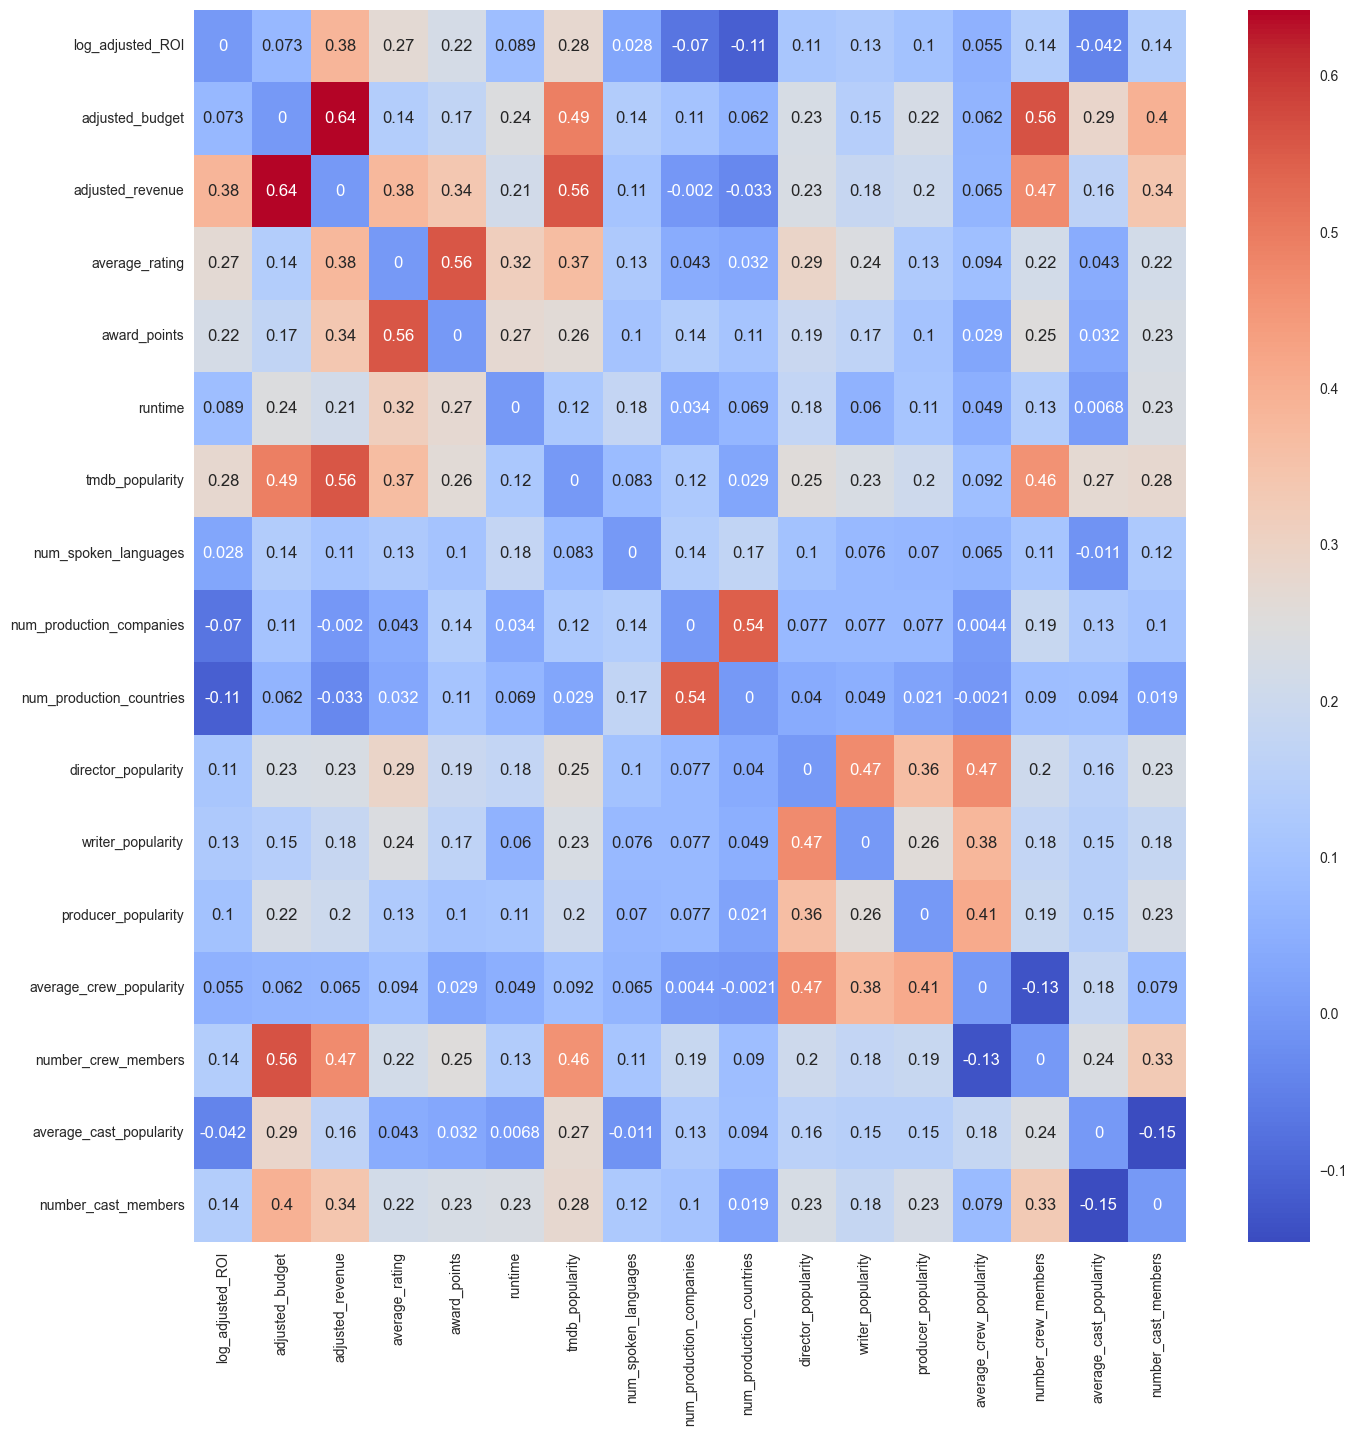

In [1183]:

corr_matrix = df[[ 'log_adjusted_ROI', "adjusted_budget", "adjusted_revenue", 
       'average_rating', 'award_points', 'runtime', 'tmdb_popularity',  'num_spoken_languages',
       'num_production_companies', 'num_production_countries', 
       'director_popularity', 
       'writer_popularity', 'producer_popularity', 'average_crew_popularity',
       'number_crew_members', 'average_cast_popularity', 'number_cast_members']].corr()

# Compute the correlation matrix for numerical features
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

plt.figure(figsize=(16, 16)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

#### !TODO: write about iterative_train_test_split and how to check???

In [1184]:
dataset_df = df[[ 'runtime',
 'rated', 
  'collection',  'is_english',
       'log_adjusted_budget',
        'fall', 
        'holidays',
       'spring', 
       'summer', 
       'winter', 
       'animation', 
       'drama', 
       'family', 
       'history',
       'horror', 
       'moderate performing', 'others', 
       'war',
       'num_spoken_languages',
       'num_production_companies', 
       'num_production_countries', 
       'is_foreign',
       'director_popularity', 
       'writer_popularity', 'producer_popularity', 'average_crew_popularity',
       'number_crew_members', 'average_cast_popularity', 
       'number_cast_members',
       ]].copy()

labels = df[["numerical_ROI_category", 'numerical_rating_category', 'numerical_award_category']]

X_np = dataset_df.to_numpy()
y_np = labels.to_numpy()

X_full_train, y_full_train, X_test, y_test = iterative_train_test_split(X_np, y_np, test_size = 0.2)
X_train, y_train, X_val, y_val = iterative_train_test_split(X_full_train, y_full_train, test_size = 0.25)

X_train_df = pd.DataFrame(X_train, columns=dataset_df.columns)  
X_val_df = pd.DataFrame(X_val, columns=dataset_df.columns)  

y_train_df = pd.DataFrame(y_train, columns=labels.columns) 
y_val_df = pd.DataFrame(y_val, columns=labels.columns)  

dv = DictVectorizer(sparse=False)
X_train_df_t = dv.fit_transform(X_train_df.to_dict(orient='records'))
X_val_df_t = dv.transform(X_val_df.to_dict(orient='records'))

# Scale the data
scaler = StandardScaler()
X_train_df_t = scaler.fit_transform(X_train_df_t)
X_val_df_t = scaler.transform(X_val_df_t)


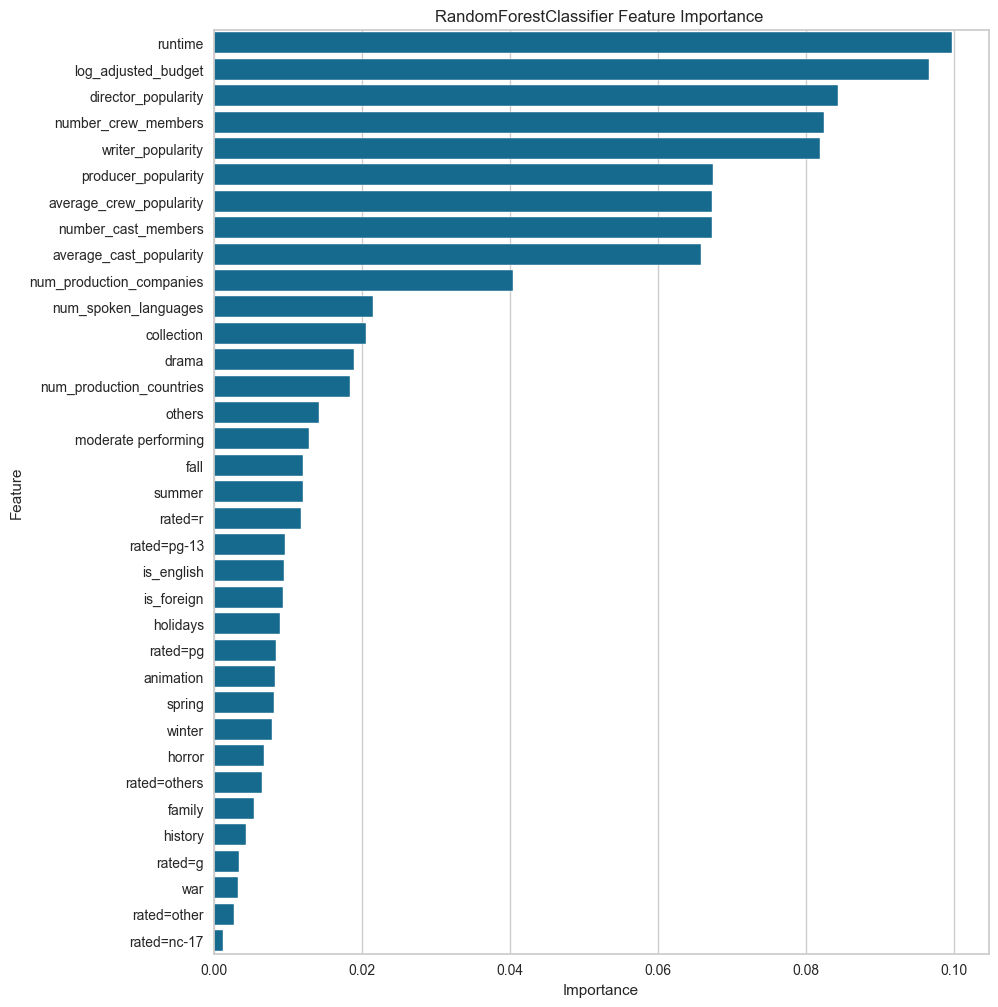

In [1185]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_df_t, y_train)

importances = random_forest_classifier.feature_importances_

feature_importances = pd.DataFrame({'feature': dv.get_feature_names_out(), 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x='importance', y='feature', data=feature_importances.sort_values('importance', ascending=False))
plt.title(f'RandomForestClassifier Feature Importance ')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.062085
0:	learn: 0.2317969	test: 0.2300156	best: 0.2300156 (0)	total: 159ms	remaining: 1m 19s
50:	learn: 0.1909003	test: 0.2113115	best: 0.2113115 (50)	total: 707ms	remaining: 6.22s
100:	learn: 0.1664069	test: 0.2041862	best: 0.2041862 (100)	total: 1.08s	remaining: 4.28s
150:	learn: 0.1461441	test: 0.1968381	best: 0.1968381 (150)	total: 1.4s	remaining: 3.24s
200:	learn: 0.1255845	test: 0.1968381	best: 0.1955021 (180)	total: 1.73s	remaining: 2.57s
250:	learn: 0.1098493	test: 0.1963928	best: 0.1955021 (180)	total: 2.05s	remaining: 2.04s
300:	learn: 0.0955986	test: 0.1997328	best: 0.1955021 (180)	total: 2.38s	remaining: 1.57s
350:	learn: 0.0848363	test: 0.1975061	best: 0.1955021 (180)	total: 2.87s	remaining: 1.22s
400:	learn: 0.0736287	test: 0.1997328	best: 0.1955021 (180)	total: 3.29s	remaining: 812ms
450:	learn: 0.0654643	test: 0.2008461	best: 0.1955021 (180)	total: 3.61s	remaining: 393ms
499:	learn: 0.0571513	test: 0.2012915	best: 0.1955021 (180)	total: 3.93s	rem

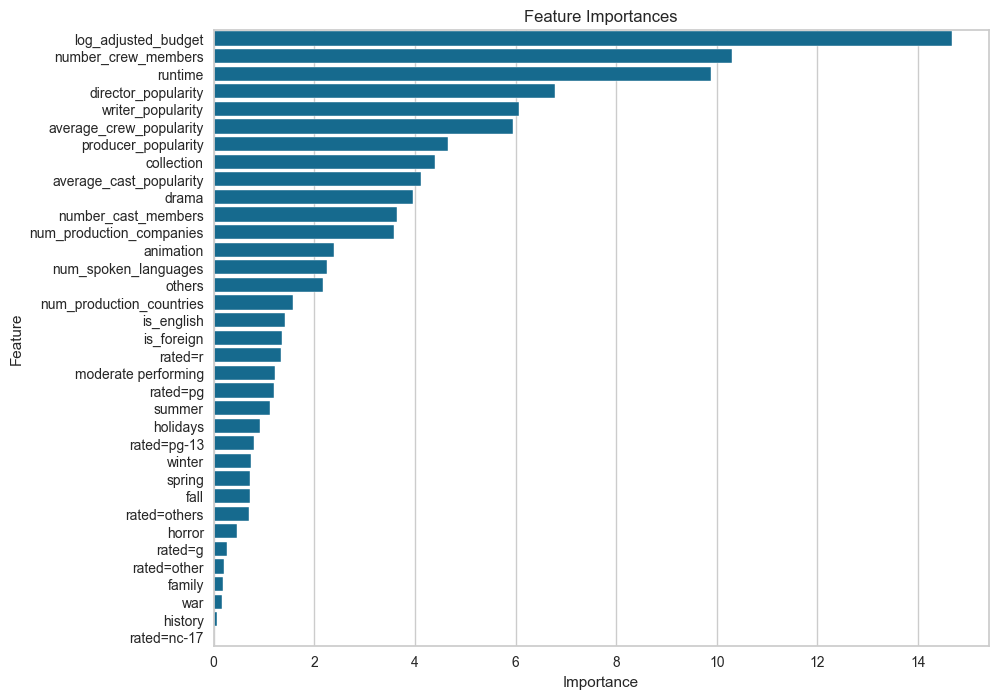

In [1186]:
train_pool = Pool(X_train_df_t, y_train)
val_pool = Pool(X_val_df_t, y_val)
catboost_classifier = CatBoostClassifier(loss_function='MultiLogloss',
    eval_metric='HammingLoss',
    iterations=500, random_state=1)
catboost_classifier.fit(train_pool, eval_set=val_pool, metric_period=10, plot=True, verbose=50)
feature_importances = catboost_classifier.get_feature_importance()

feature_names =  dv.get_feature_names_out() 
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.show()


In [1187]:

df[[ 'runtime',
 #'rated', 
  'collection',  'is_english',
  'log_adjusted_budget',
        #'fall', 
        #'holidays',
       #'spring', 
       #'summer', 
       'winter', 
       'animation', 
       'drama', 
       #'family', 
       #'history',
       #'horror', 
       'moderate performing', 'others', 
       #'war',
       'num_spoken_languages',
       'num_production_companies', 
       'num_production_countries', 
       'is_foreign',
       'director_popularity', 
       'writer_popularity', 'producer_popularity', 'average_crew_popularity',
       'number_crew_members', 'average_cast_popularity', 
       'number_cast_members', "numerical_ROI_category", 'numerical_rating_category', 'numerical_award_category'
       ]].to_parquet('../data/cleaned/selected_features.parquet')